# <font color ="blue"> Protein Expression in Mice with Down Syndrome </font>
### *BCG - Machine Learning Homework 2020*
**Veronica Erconi - veronica.erconi@mail.polimi.it**

## 1. Background
‹‹**Down syndrome (DS)** is a chromosomal abnormality associated with intellectual disability and
affecting approximately one in 1000 live births worldwide. It is due to an extra copy of the long arm of
**human chromosome 21 (Hsa21)** and the consequent increased level of expression, due to dosage, of
some subset of the genes it encodes. The overexpression of genes encoded by the extra copy of a nor-
mal chromosome in DS is believed to be sufficient to perturb normal pathways and normal responses
to stimulation, causing learning and memory deficits. The **memantine drug** is currently in use for
treatment of moderate to severe Alzheimer’s Disease (AD) and has been proposed for treatment of
learning deficits in DS. While memantine is known to modulate excitatory neurotransmission through
antagonizing activity of N-methyl-D-aspartate (NMDA) receptors, **little is known about its effects on
protein expression**, either alone or with learning paradigms.
In this dataset, **the effect of memantine on protein responses is studied in the partial trisomy mouse
model of DS, named Ts65Dn**. Untreated Ts65Dn mice fail to learn in context fear conditioning CFC
but if they are first injected with memantine, they learn successfully, i.e., learning is rescued. Protein
lysates were prepared from brains of 3 month old male Ts65Dn Down syndrome model mice and their
male littermate wild type controls, after training in context fear conditioning (CFC) with and without
injection with the drug memantine. The context-shock (CS) group of mice are placed in a novel cage,
allowed to explore for several minutes and then given a brief electric shock; normal, wildtype mice
learn to associate the novel context with the aversive stimulus and will freeze upon re-exposure to the
same cage. To control for the effects of the shock alone, a second group of mice, the shock-context
(SC) group, are placed in the novel cage, immediately given the electric shock, and then allowed to
explore; with these conditions, normal, wild type mice do not learn to associate the novel cage with
the shock and do not freeze upon re-exposure to the same cage. Unlike their wild type littermates, the
Ts65Dn CS group of mice fail to learn and do not freeze; **this learning impairment can be corrected,
however, if the Ts65Dn are injected with memantine prior to training**. To control for the effects of
injection alone, an additional CS group is also injected with saline (no drug). ››
— *Higuera, Clara, Katheleen J. Gardiner, and Krzysztof J. Cios. “Self-organizing feature maps
identify proteins critical to learning in a mouse model of down syndrome.” PloS one 10.6 (2015).*

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
import sklearn
import random
import scipy
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.hierarchy import dendrogram
from scipy import stats
from scipy.stats import t, f
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, scale, normalize
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from scipy.cluster.hierarchy import linkage
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import r2_score, mean_squared_error, make_scorer, silhouette_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.svm import SVC
from statsmodels.stats.outliers_influence import variance_inflation_factor
np.random.seed(0)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
#we define a useful function for representation
def plot3d(X, labels):
    # Set matplotlib as interactive
    # &matplotlib inline
    # Set matplotlib to generate static images
    #%matplotlib notebook
    # This import is required to set up the 3D environment
    
    pca = PCA(n_components=3)
    X = pca.fit_transform(X)
    
    unique_labels = np.unique(labels)
    # Convert negative values (outliers) into positive
    labels = labels.copy()
    labels += np.abs(unique_labels.min())
    nlabels = len(unique_labels)
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111, projection='3d')
    # Define color mappings
    col = ("bwr" if nlabels <= 2 else
          ("Dark2" if nlabels > 2 & nlabels <= 8 else
           "hsv"))
    cmap = plt.cm.get_cmap(col)
    smap = cm.ScalarMappable(
              norm=mcolors.Normalize(unique_labels.min(), unique_labels.max()+1), 
              cmap=cmap)
    # Plot the 3d coordinates 
    ax.scatter(xs=X[:, 0], ys=X[:, 1], zs=X[:, 2], c=labels, cmap=cmap)
    # Plot a color bar on the right
    plt.colorbar(mappable=smap, label='digit label', ticks=range(nlabels))

## 2. Dataset Composition

The data set consists of the expression levels of 76 proteins/protein modifications that produced detectable
signals in the nuclear fraction of the cortex. The 77th column describe eight classes of mice based on features such as genotype, control (c) or trisomic (t), behavior, stimulated to learn (context-shock (CS)) or not (shock-context (SC)) and memantine injection (m) or saline (s). Samples have been split into **train** (367 samples x 76 protein expression+class) and **test** (245 samples x 75 protein expression+ class) sets. 
**NB.** A malfunctioning in the analysis procedure caused the measurements of the SOD1_N protein expression to be lost in all test samples.
Features are all real values and no data is missing, except from the SOD1_N feature on test samples.

In [3]:
#Select directory in which you have the dataset and on which you want to work
os.chdir("/home/veronica/bcg-2020/machine_learning/homework")
cwd = os.getcwd()
cwd

'/home/veronica/bcg-2020/machine_learning/homework'

In [4]:
##LOADING DATASETS

train_dataset= pd.read_csv(cwd + "/train.csv")
train_dataset.shape
train_dataset.head()

test_dataset= pd.read_csv(cwd + "/test.csv")
test_dataset.shape
test_dataset.head()

train_dataset.columns.get_loc("SOD1_N")

(367, 77)

DYRK1A_N   ITSN1_N    BDNF_N     NR1_N    NR2A_N    pAKT_N   pBRAF_N  \
0  0.650511  1.158653  0.580172  2.230388  3.179675  0.533686  0.440101   
1  0.365907  0.651296  0.810468  2.597217  4.131603  0.537554  0.249235   
2  0.260145  0.397996  0.229522  2.643311  4.303648  0.268394  0.050916   
3  0.239489  0.271240  0.766816  1.872419  2.424971  0.322269  0.386791   
4  0.617112  0.751737  0.050685  2.356175  3.494138  0.506875  0.310644   

   pCAMKII_N   pCREB_N    pELK_N  ...     SHH_N     BAD_N     pS6_N   pCFOS_N  \
0   5.033898  0.200985  1.589221  ...  0.047287  0.337121  0.203356  0.191360   
1   6.099538  0.226362  1.700578  ...  0.521112  0.419544  0.231619  0.393897   
2   3.130455  0.273792  2.534531  ...  0.047407  0.053130  0.096325  0.257402   
3   2.351832  0.034265  0.472725  ...  0.273651  0.162382  0.234056  0.180657   
4   3.855825  0.309879  1.033428  ...  0.172488  0.014086  0.191145  0.149622   

      SYP_N  H3AcK18_N    EGR1_N  H3MeK4_N    CaNA_N   class  
0  0.590874   0.112145  0.110109  0.160637  1.329248  t-CS-m  
1  0.252572   0.352687  0.085545  0.328537  1.008023  t-SC-s  
2  0.246015   0.203979  0.039188  0.008315  1.193634  c-SC-s  
3  0.351388   0.103896  0.302341  0.166020  0.689970  c-CS-m  
4  0.310434   0.151685  0.180055  0.383039  1.737274  t-CS-s  

[5 rows x 77 columns]

(245, 76)

DYRK1A_N   ITSN1_N    BDNF_N     NR1_N    NR2A_N    pAKT_N   pBRAF_N  \
0  0.179263  0.066807  0.415744  1.689743  3.341121  0.544789  0.013569   
1  0.292189  0.721669  0.461519  2.405523  4.632695  0.070489  0.152357   
2  0.618632  0.880618  0.437260  2.339360  3.875806  0.129437  0.047842   
3  0.356012  0.646883  0.450320  2.478821  3.772100  0.122035  0.076693   
4  0.207957  0.402249  0.271787  1.596307  3.073973  0.106266  0.259618   

   pCAMKII_N   pCREB_N    pELK_N  ...     SHH_N     BAD_N     pS6_N   pCFOS_N  \
0   4.505120  0.131921  1.145255  ...  0.140915  0.230128  0.189588  0.314862   
1   3.563931  0.457679  1.798422  ...  0.045180  0.544333  0.273302  0.397962   
2   4.920675  0.350683  1.492872  ...  0.299862  0.075939  0.344712  0.131191   
3   3.225882  0.084315  1.195571  ...  0.409750  0.079850  0.025022  0.102514   
4   2.467713  0.340771  0.891961  ...  0.501047  0.009205  0.113849  0.186703   

      SYP_N  H3AcK18_N    EGR1_N  H3MeK4_N    CaNA_N   class  
0  0.144272   0.302491  0.086637  0.042029  0.998893  c-SC-m  
1  0.277610   0.155784  0.065486  0.093071  1.576650  c-SC-s  
2  0.003888   0.035925  0.330201  0.035484  1.749580  c-CS-m  
3  0.352965   0.080953  0.272696  0.218447  1.322880  t-SC-s  
4  0.468138   0.206692  0.211410  0.114422  1.482459  c-SC-s  

[5 rows x 76 columns]

32

## 3. Preliminary Analysis

### 3.1 Training dataset description and visualization

The number of mice for each class of the training dataset was:
- 48 control mice, stimulated to learn, injected with saline
- 57 trisomy mice, stimulated to learn, injected with saline
- 36 control mice, stimulated to learn, injected with memantine
- 57 trisomy mice, stimulated to learn, injected with memantine
- 45 control mice, not stimulated to learn, injected with saline
- 58 trisomy mice, not stimulated to learn, injected with saline
- 28 control mice, not stimulated to learn, injected with memantine
- 38 trisomy mice, not stimulated to learn, injected with memantine

To better visualize the amount of mice assigned to each class for the experiment and the expression 
profile of each mice we decided to plot a piechart and a 3D plot using PCA dimensionality reduction for visualization.

In [5]:
#![](topinopiec.jpg)

([<matplotlib.patches.Wedge at 0x7f006b813810>,
 [Text(0.49009181734500173, 0.9847893229373853, 'c-CS-s'),
  Text(-0.465591143538884, 0.9966066862399402, 't-CS-s'),
  Text(-1.0378885236276505, 0.3644000720664258, 'c-CS-m'),
  Text(-0.9864153348182582, -0.48681083311218953, 't-CS-m'),
  Text(-0.26062859289701534, -1.0686780322269762, 'c-SC-s'),
  Text(0.659110359269507, -0.8806665284337889, 't-SC-s'),
  Text(1.0797599779297906, -0.2100437812958483, 'c-SC-m'),
  Text(1.024424524644662, 0.4006923923741984, 't-SC-m')],
 [Text(0.26732280946091, 0.537157812511301, '13.1%'),
  Text(-0.25395880556666395, 0.5436036470399673, '15.5%'),
  Text(-0.5661210128878092, 0.19876367567259584, '9.8%'),
  Text(-0.5380447280826862, -0.2655331816975579, '15.5%'),
  Text(-0.14216105067109927, -0.5829152903056233, '12.3%'),
  Text(0.35951474141973105, -0.4803635609638848, '15.8%'),
  Text(0.5889599879617039, -0.11456933525228088, '7.6%'),
  Text(0.5587770134425428, 0.21855948674956274, '10.4%')])

(-1.1047366677392234,
 1.1030248527094813,
 -1.108854690357484,
 1.1077749707056477)

Text(0.5, 1.0, 'Mice classes in training dataset')

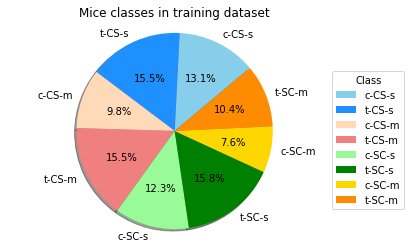

In [6]:
#class labels
labels = "c-CS-s", "t-CS-s", "c-CS-m", "t-CS-m", "c-SC-s", "t-SC-s", "c-SC-m", "t-SC-m"

#number of mice for each class
sizes = [48, 57, 36, 57, 45, 58, 28, 38]

#cold colors for saline, warm colors for memantine, light colors for controls and darker colors for trisomy
colors = ["skyblue", "dodgerblue", "peachpuff", "lightcoral", "palegreen", "g", "gold", "darkorange"]
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',shadow=True, startangle=40)
ax.axis('equal')  # relative frequency % of the class
ax.legend(labels,title="Class",loc=0, bbox_to_anchor=(0.7, 0.3, 0.5, 0.5))
ax.set_title("Mice classes in training dataset")
plt.show()


			 3D Visualization of raw training data


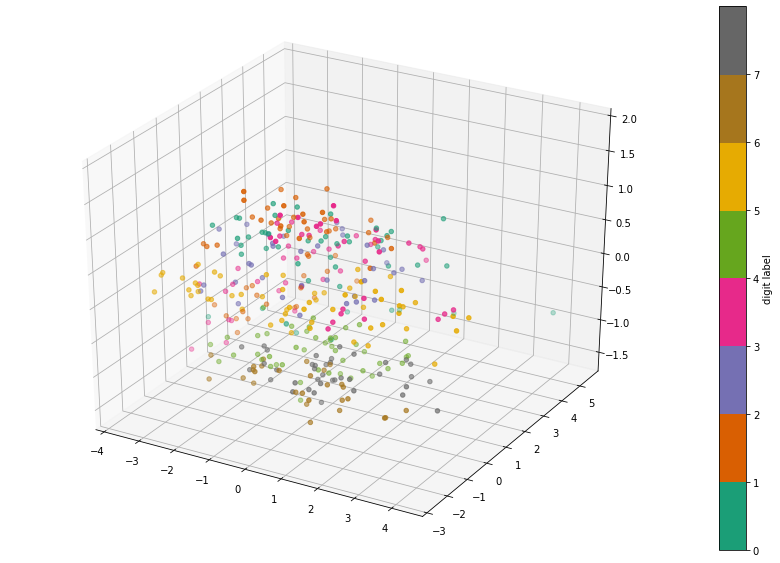

In [7]:
#first of all we generate the dictionary with key class name and associated number
conversion_dict = {"c-CS-s":0, "t-CS-s":1, "c-CS-m":2, "t-CS-m":3, "c-SC-s":4, "t-SC-s":5, "c-SC-m":6, "t-SC-m":7}

#we replace the strings representing class labels with integer values from 0 to 7
train_conv = train_dataset.replace({"class": conversion_dict})

#we devide our dataframe in inputs and external information about lables
feat_n = train_conv.drop("class", axis=1)
cl = train_conv["class"]
print("\n\t\t\t 3D Visualization of raw training data")
plot3d (feat_n, labels = cl)

From the 3D graph inspection we observed samples belonging to the same class to aggregates in wide regions. Moreover, in some cases observations of different classes seem to be near eachother making difficult to find the presence of groups at the naked eye.

### 3.2 Features correlation and visualization

To understand better our training dataset we performed different analysis to visualize the features and to investigate their correlation between eachother.

<Figure size 720x720 with 0 Axes>

Text(0.5, 1, 'Correlation matrix of training dataset')

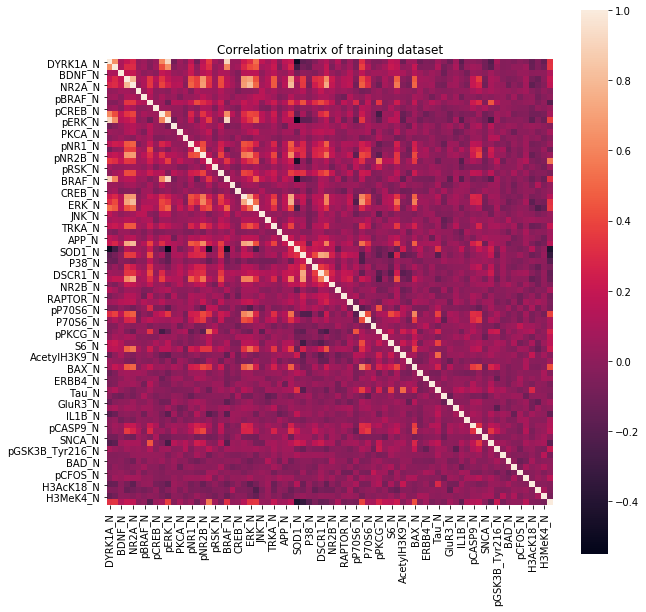

In [8]:
#pairwise correlation of all our features
plt.figure(figsize=(10, 10))
sns.heatmap(train_dataset.corr(), square=True, annot=False, annot_kws={'fontsize': 15}, cbar= True).set_title("Correlation matrix of training dataset")

From this heatmap that summarise the pairwise correlation of all the features we identified the presence of correlations between them. Since the evaluation of that number of corrlation was cahotic, we decided to deepen our investigations by cheking if visible differences in correlation between features based on classes.

<Figure size 1656x3096 with 0 Axes>

Text(0.5, 1, 'Class: c-CS-s')

Text(0.5, 1, 'Class: t-CS-s')

Text(0.5, 1, 'Class: c-CS-m')

Text(0.5, 1, 'Class: t-CS-m')

Text(0.5, 1, 'Class: c-SC-s')

Text(0.5, 1, 'Class: t-SC-s')

Text(0.5, 1, 'Class: c-SC-m')

Text(0.5, 1, 'Class: t-SC-m')

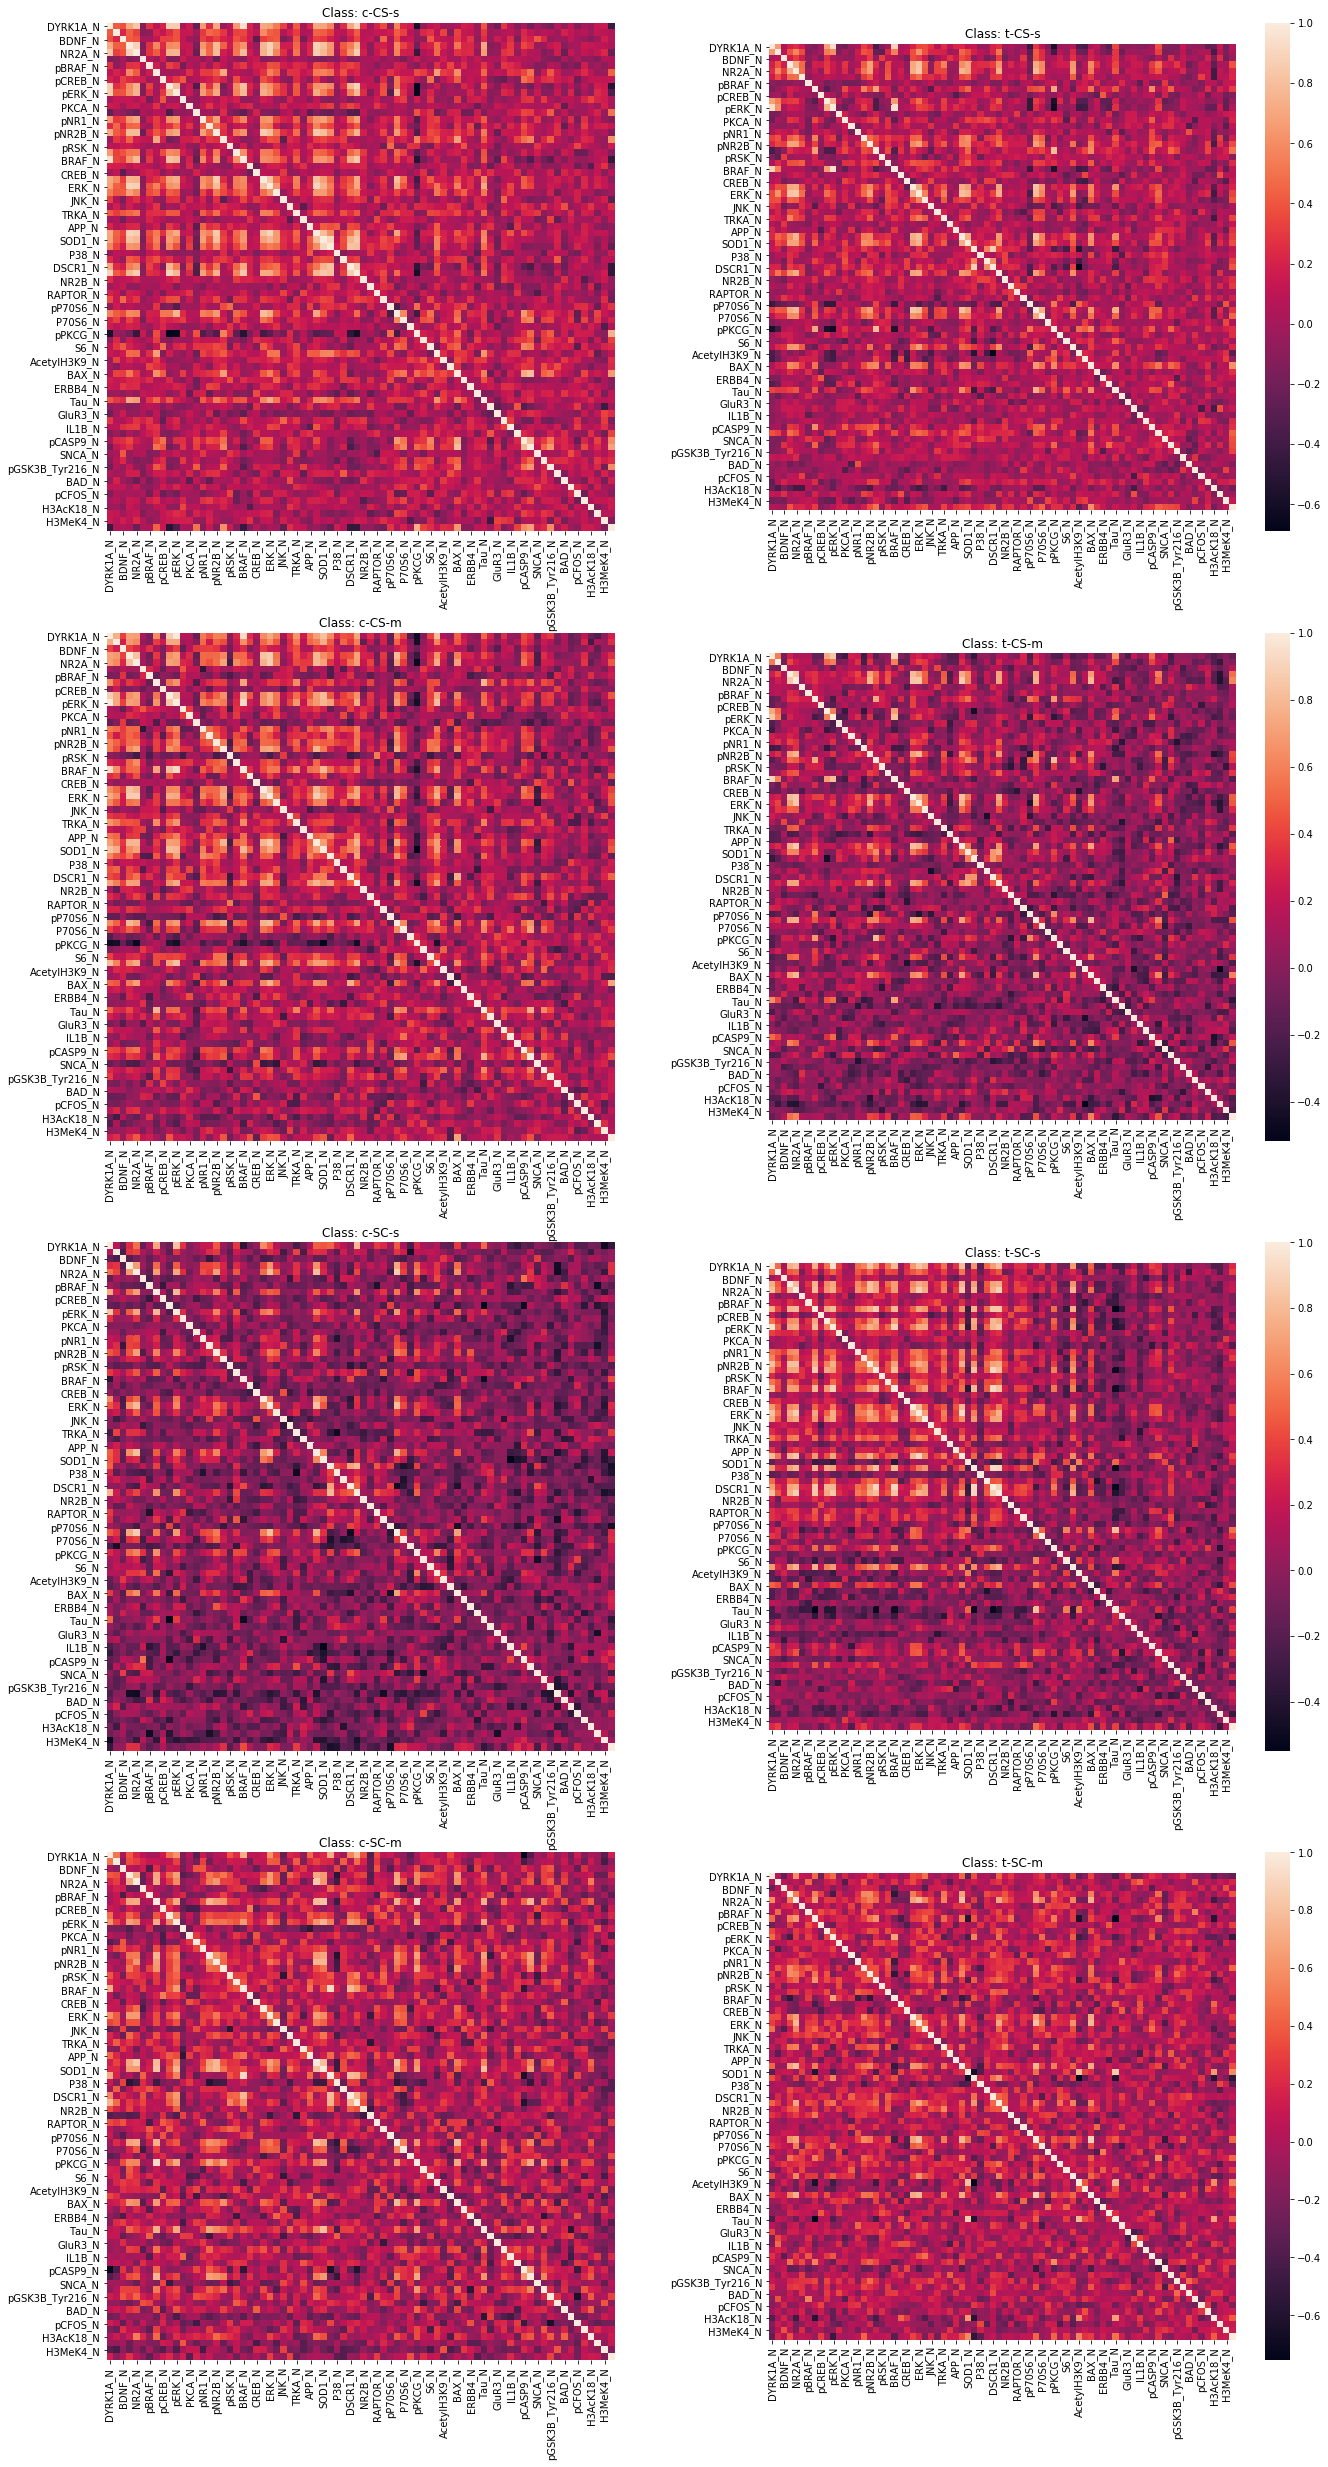

In [9]:
#check if the correlation between theh features is equal for all the classes
c_d={}
cl_list= ["c-CS-s", "t-CS-s", "c-CS-m", "t-CS-m", "c-SC-s", "t-SC-s", "c-SC-m", "t-SC-m"]
#obtain different dataframes with mice of each class
for cl in cl_list:
    x = train_dataset[train_dataset ["class"] == cl]
    corr = x.corr(method= "pearson")
    c_d[cl] = corr
    
#Plotting the heatmaps
plt.figure(figsize=(23,43))
counter=0

for k, c in c_d.items():
    counter+=1
    plt.subplot(4,2,counter)
    if (counter % 2) != 0 :
        sns.heatmap(c, square=True, annot=False, annot_kws={'fontsize': 15}, 
                    cbar= False).set_title("Class: " + k)
    else:
        sns.heatmap(c, square=True, annot=False, annot_kws={'fontsize': 15}, 
                    cbar= True).set_title("Class: " + k)

In particular, during the evaluation of the expression of all the proteins with boxplots, we noticed the presence of a subgroup of proteins with visible different expression in mice belonging to different classes.
We chose SOD1_N and pERK_N as examples for visualization and we noticed lower expression values of SOD1_N in mice stimulated to learn and lower values of pERK_N in mice stimulated to learn independently of presence of trisomy of treatment.

Text(0.5, 0.98, 'Protein expression in each class')

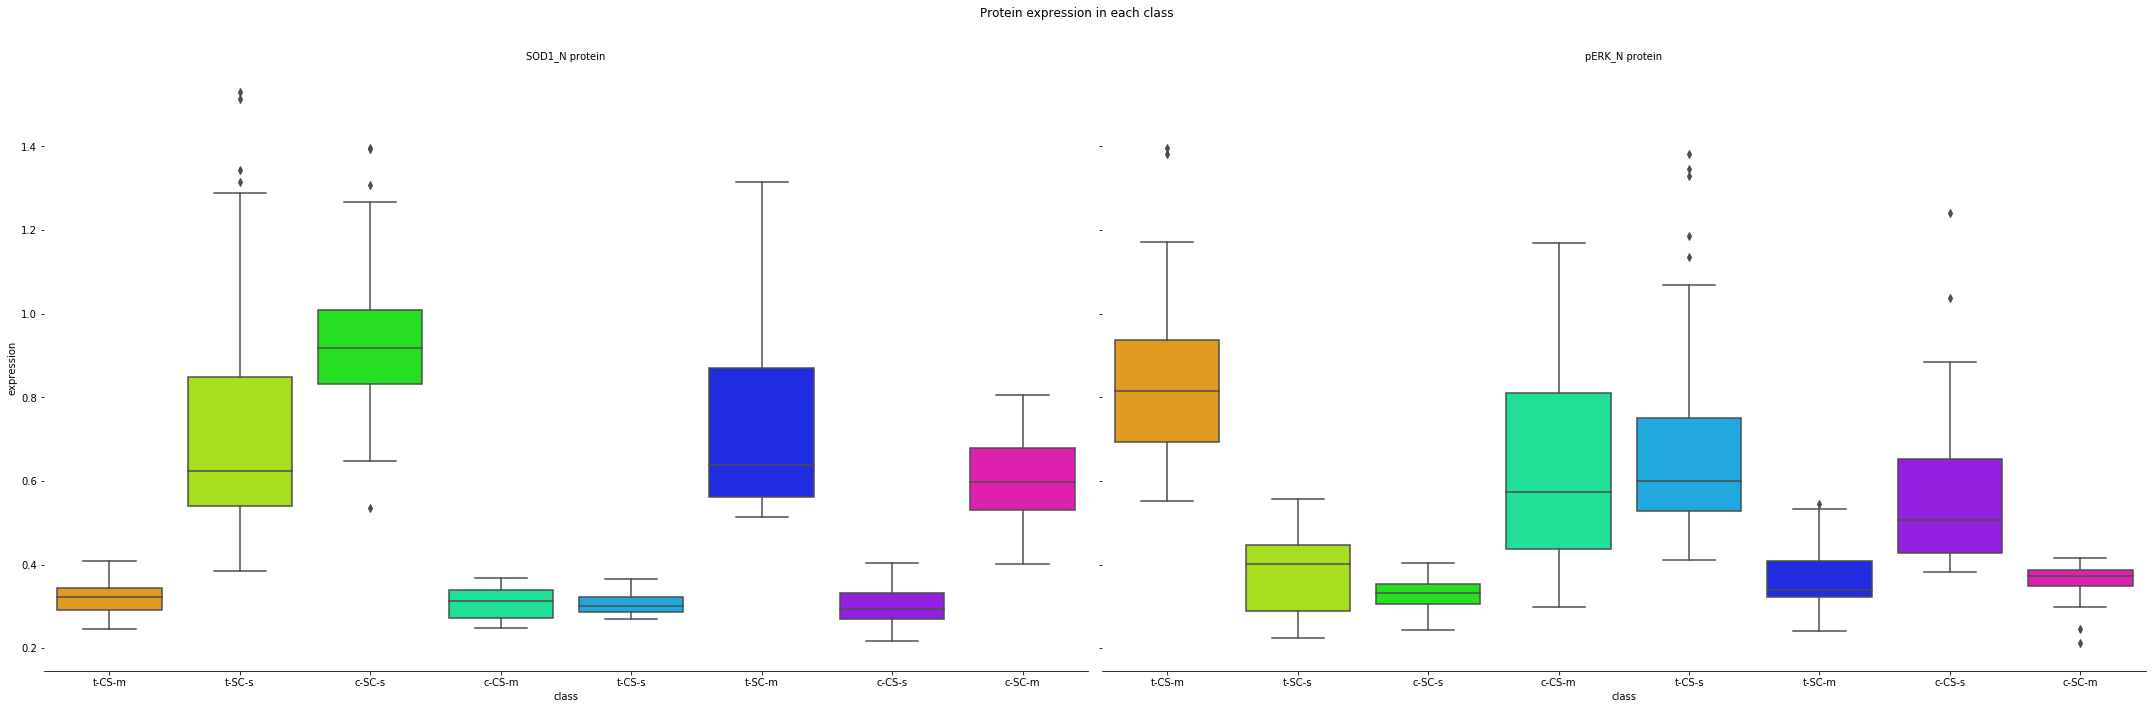

In [10]:
red = train_dataset[['SOD1_N', 'pERK_N', 'class']]
red_long = red.melt(id_vars="class", var_name="protein", value_name="expression")

overall_plot= sns.catplot(data=red_long,
                            x='class',
                            y='expression',
                            col='protein',
                            col_wrap=2,
                            kind='box',
                            height=10, 
                            aspect=1.5,
                            palette="hsv")
plt.subplots_adjust(top=0.9)
overall_plot.fig.suptitle('Protein expression in each class')
(overall_plot.set_axis_labels("class", "expression")
   .set_titles("{col_name} {col_var}")
   .despine(left=True)) 


Then, to investigate whether the most variable features were correlated between eachother and in particular, if their correlation depends on class, we plotted an heatmap and a pairplot.

<Figure size 1296x2304 with 0 Axes>

Text(0.5, 1, 'Class: c-CS-s')

Text(0.5, 1, 'Class: t-CS-s')

Text(0.5, 1, 'Class: c-CS-m')

Text(0.5, 1, 'Class: t-CS-m')

Text(0.5, 1, 'Class: c-SC-s')

Text(0.5, 1, 'Class: t-SC-s')

Text(0.5, 1, 'Class: c-SC-m')

Text(0.5, 1, 'Class: t-SC-m')

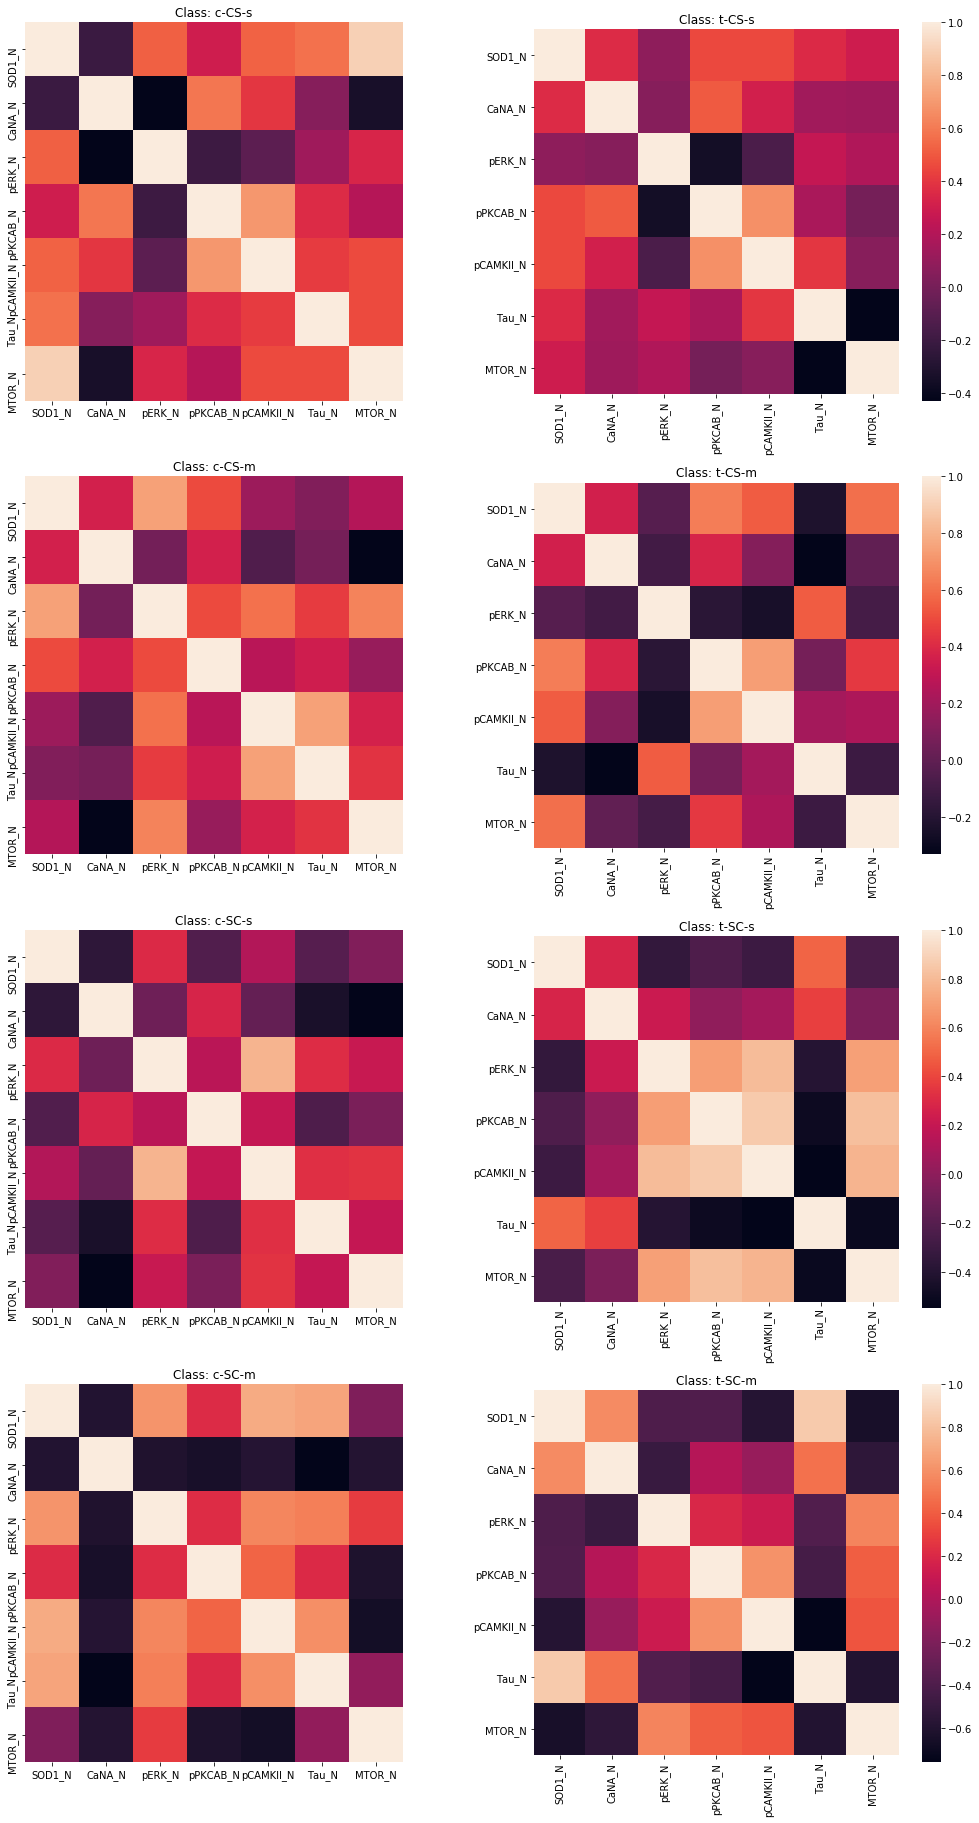

In [11]:
restr= train_dataset[['SOD1_N', 'CaNA_N','pERK_N', 'pPKCAB_N', 'pCAMKII_N', 'Tau_N', 'MTOR_N', 'class']]

for cl in cl_list:
    x = restr[restr["class"] == cl]
    corr = x.corr(method= "pearson")
    c_d[cl] = corr
    
#Plotting the heatmaps
plt.figure(figsize=(18,32))
counter=0

for k, c in c_d.items():
    counter+=1
    plt.subplot(4,2,counter)
    if (counter % 2) != 0 :
        sns.heatmap(c, square=True, annot=False, annot_kws={'fontsize': 9}, 
                    cbar= False).set_title("Class: " + k)
    else:
        sns.heatmap(c, square=True, annot=False, annot_kws={'fontsize': 9}, 
                    cbar= True).set_title("Class: " + k)

Text(0.5, 1.06, 'Pairplot of proteins whith most variable expression between classes')

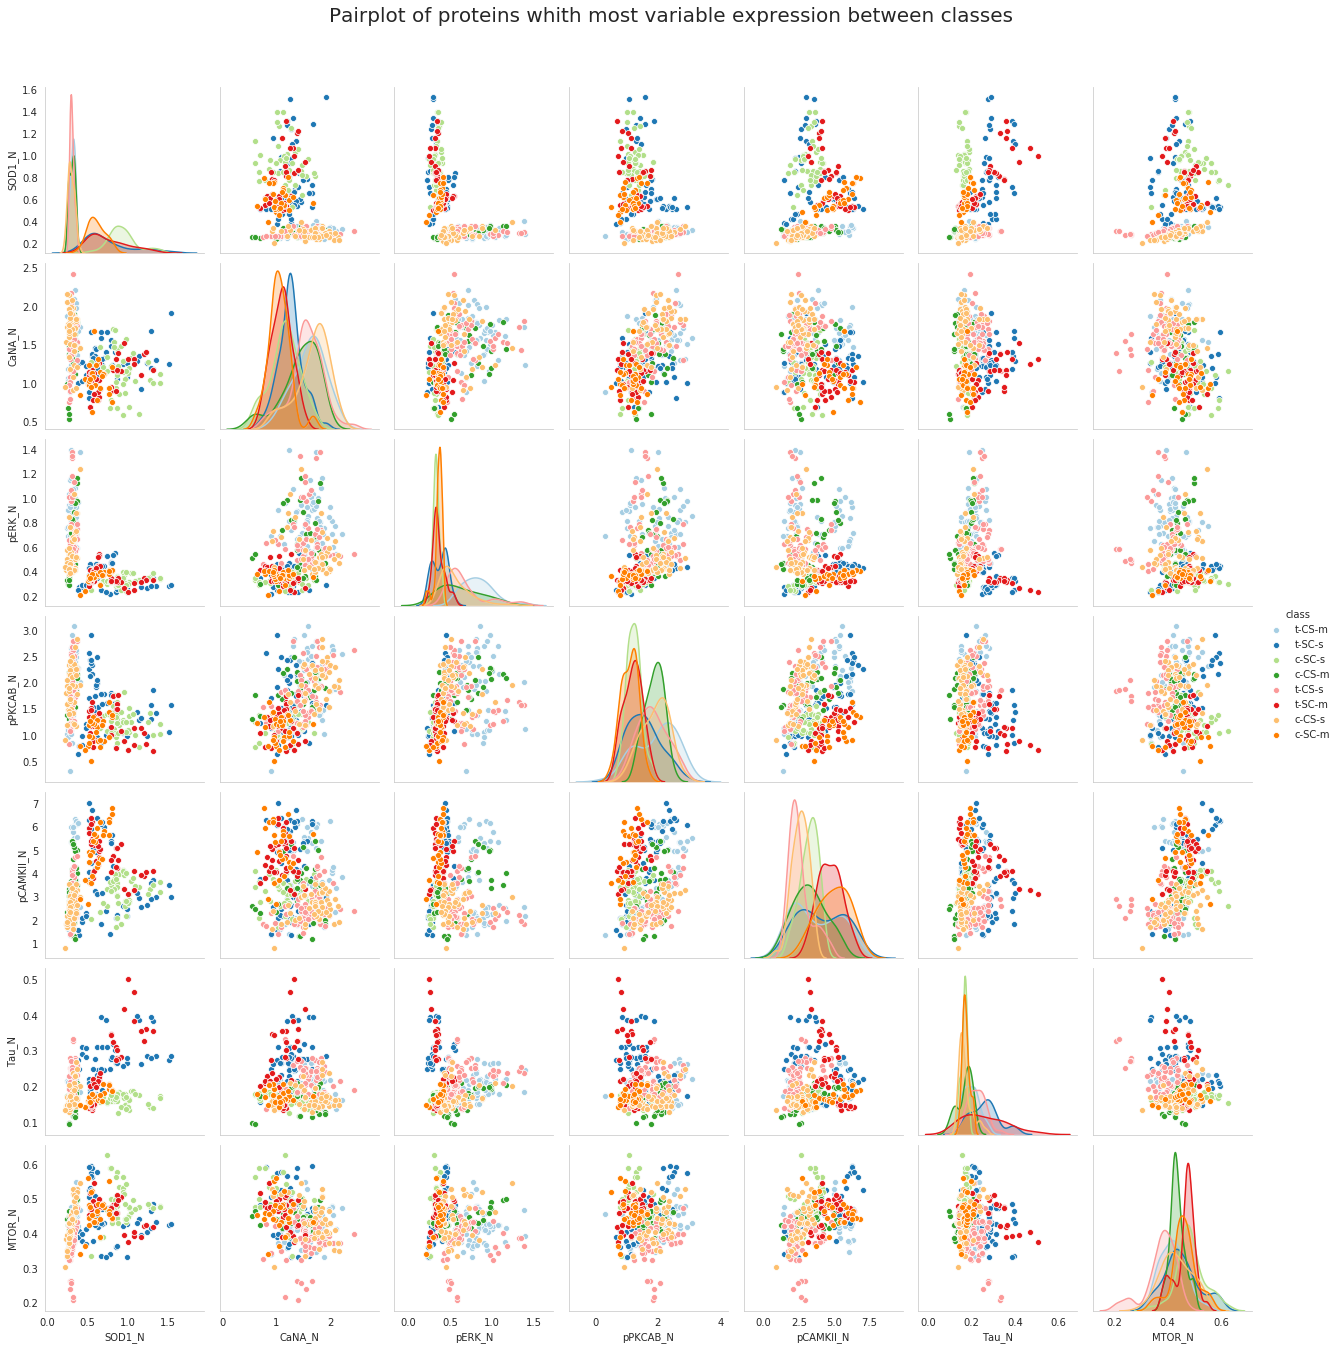

In [12]:
#correlation between features has different coefficients based on class
#to investigate better with focus on the class
sns.set_style("whitegrid", {'axes.grid' : False})
g = sns.pairplot(train_dataset[['SOD1_N', 'CaNA_N','pERK_N', 'pPKCAB_N', 'pCAMKII_N', 'Tau_N', 'MTOR_N', 'class']],
                 hue="class",palette= "Paired", diag_kind="kde")
g.fig.suptitle( "Pairplot of proteins whith most variable expression between classes", y=1.06, fontsize= 20)
plt.show()

Finally, after observing that many features resulted statistically associated between eachother pairwise,
we wanted to investigate the presence of multicollinearity in order to understand wether to deal with this problem in the following analysis.
To do so we evaluated the variance inflation factor VIF that helps to understand how much each predictor 
is explained by others.

In [13]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

V = calc_vif(train_conv)
col = V.loc[(V['VIF'] > 5)]
col.shape

(48, 2)

We observed 48 features with VIF value greater than five (some also >100) and thus showing multicollinearity. 

### 3.3 General exploratory analysis - Clustering 

In order to identify structures and relations in our input data, we performed a general exploratory analysis using different unsupervised learning algorithms: Agglomerative, K-means and DBSCAN clustering.

In [14]:
#remember of what we had done with the dataset
conversion_dict = {"c-CS-s":0, "t-CS-s":1, "c-CS-m":2, "t-CS-m":3, "c-SC-s":4, "t-SC-s":5, "c-SC-m":6, "t-SC-m":7}
train_conv = train_dataset.replace({"class": conversion_dict})
feat_n = train_conv.drop("class", axis=1)
#to improve clustering efficiency of the clustering we normalized the data
feat = preprocessing.normalize(feat_n)
cl = train_conv["class"]
print ("Rows, columns of input dataframe and class dataframe we will use are respectively: \n ", feat.shape, "and", cl.shape)

Rows, columns of input dataframe and class dataframe we will use are respectively: 
  (367, 76) and (367,)


In [15]:
#definition of functions useful to perform dendrogram and plotting the result of the clustering
def plot_dendrogram(Z=None, model=None, X=None, **kwargs):
    annotate_above = kwargs.pop('annotate_above', 0)

    # Reconstruct the linakge matrix if the standard model API was used
    if Z is None:
        if hasattr(model, 'distances_') and model.distances_ is not None:
            # create the counts of samples under each node
            counts = np.zeros(model.children_.shape[0])
            n_samples = len(model.labels_)
            for i, merge in enumerate(model.children_):
                current_count = 0
                for child_idx in merge:
                    if child_idx < n_samples:
                        current_count += 1  # leaf node
                    else:
                        current_count += counts[child_idx - n_samples]
                counts[i] = current_count

            Z = np.column_stack([model.children_, model.distances_,
                                              counts]).astype(float)
        else:
            Z = linkage(X, method=model.linkage, metric=model.affinity)
    
    if 'n_clusters' in kwargs:
        n_clusters = kwargs.pop('n_clusters')
        # Set the cut point just above the last but 'n_clusters' merge
        kwargs['color_threshold'] = Z[-n_clusters, 2] + 1e-6
    
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    # Plot the corresponding dendrogram
    ddata = dendrogram(Z, ax=ax, **kwargs) 
    
    # Annotate nodes in the dendrogram
    for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
        x = 0.5 * sum(i[1:3])
        y = d[1]
        nid = np.where(Z[:,2] == y)[0][0]
        if y > annotate_above:
            plt.plot(x, y, 'o', c=c)
            plt.annotate(str(nid-Z.shape[0]), (x, y), xytext=(0, -5),
                         textcoords='offset points',
                         va='top', ha='center')
    if kwargs['color_threshold']:
        plt.axhline(y=kwargs['color_threshold'], c='k')
    
    return fig, ax

def sorted_sim(sim, y_pred):
    idx_sorted = np.argsort(y_pred)
    # Sort the rows
    sim = sim[idx_sorted]
    # Sort the columns
    sim = sim[:, idx_sorted]
    
    return sim

def wss(X, y_pred, metric):
    ncluster = np.unique(y_pred).shape[0]
    err = 0
    for k in range(ncluster):
        # All the points of this cluster
        X_k = X[y_pred == k]
        # Distances of all points within the cluster
        dist_mat = pairwise_distances(X_k, metric=metric)
        # Select the lower triangular part of the matrix
        triu_idx = np.tril_indices(dist_mat.shape[0], k=1)
        err += (dist_mat[triu_idx] ** 2).sum()
    
    return err

def bss(X, y_pred, metric):
    ncluster = np.unique(y_pred).shape[0]
    # Sort the distance matrix (as we did for the simiarity)
    dist_mat = pairwise_distances(X, metric=metric) ** 2
    dist_mat = sorted_sim(dist_mat, y_predict)
    y_sort = np.sort(y_pred)
    
    err = 0
    for k in range(ncluster):
        kidx = np.where(y_sort == k)[0]
        start, end = kidx[0], kidx[-1]
        err += dist_mat[start:end, end+1:].sum()
    
    return err
    
def get_Ncounts(y_predict, y_true, k, j=None):
    N = y_true.shape[0]
    Nk_mask = y_predict == k
    Nk = Nk_mask.sum()
    Nj, Nkj = None, None
    if j is not None:
        Nj_mask = y_true == j
        Nj = Nj_mask.sum()
        Nkj = np.logical_and(Nj_mask, Nk_mask).sum()
    return N, Nk, Nj, Nkj

def precision(y_predict, y_true, k, j):
    N, Nk, Nj, Nkj = get_Ncounts(y_predict, y_true, k, j)
    return Nkj / (Nk + 1e-8)
    
def recall(y_predict, y_true, k, j):
    N, Nk, Nj, Nkj = get_Ncounts(y_predict, y_true, k, j)
    return Nkj / (Nj + 1e-8)

def F(y_predict, y_true, k, j):
    p = precision(y_predict, y_true, k, j)
    r = recall(y_predict, y_true, k, j)
    return (2*p*r) / (p+r)

def purity(y_predict, y_true, k):
    cls = np.unique(y_true)
    prec = [precision(y_predict, y_true, k, j) for j in cls]
    return max(prec)

def tot_purity(y_predict, y_true):
    N = y_true.shape[0]
    nc = len(np.unique(y_true))
    p = 0
    for k in range(nc):
        N, Nk, _, _ = get_Ncounts(y_predict, y_true, k)
        pk = purity(y_predict, y_true, k)
        p += (Nk / N) * pk
    return p

##### 3.3.1 Hierarchical bottom up clustering

Firstly, we performed the agglomerative clustering since it provides the possibility to choose the number of cluster after clustering. We decided to use Pearson's Correlation metrics between points and we tried different linkages, such as single, average and complete, to choose the best dendrogram result based on the between clusters distances showed by the dendrogram.

Text(0.5, 1.0, 'single')

Text(0.5, 1.0, 'average')

Text(0.5, 1.0, 'complete')

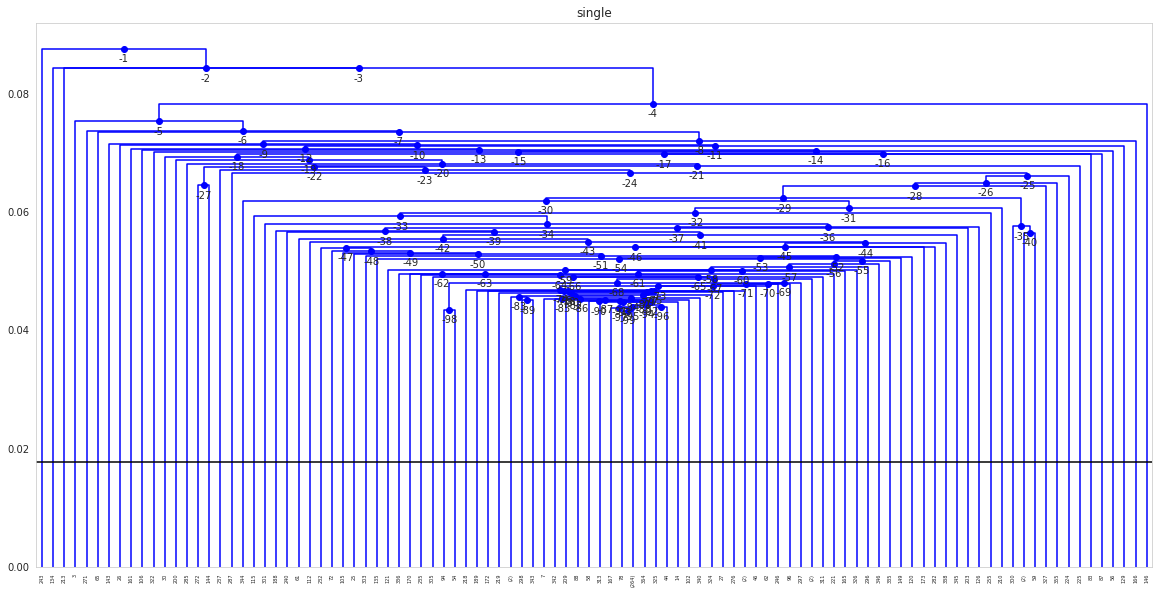

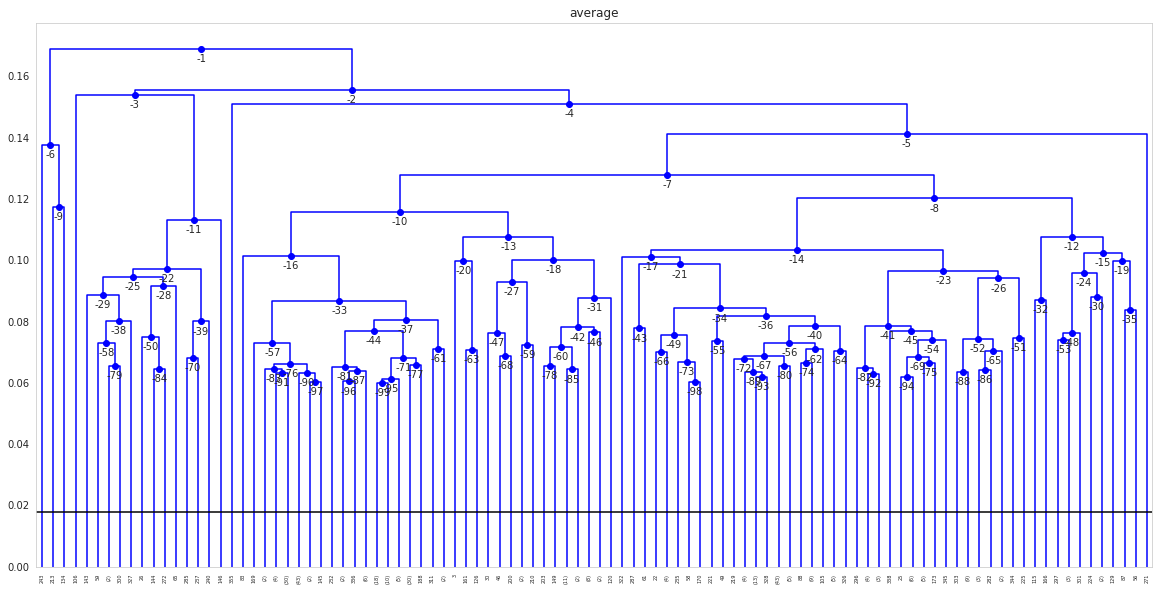

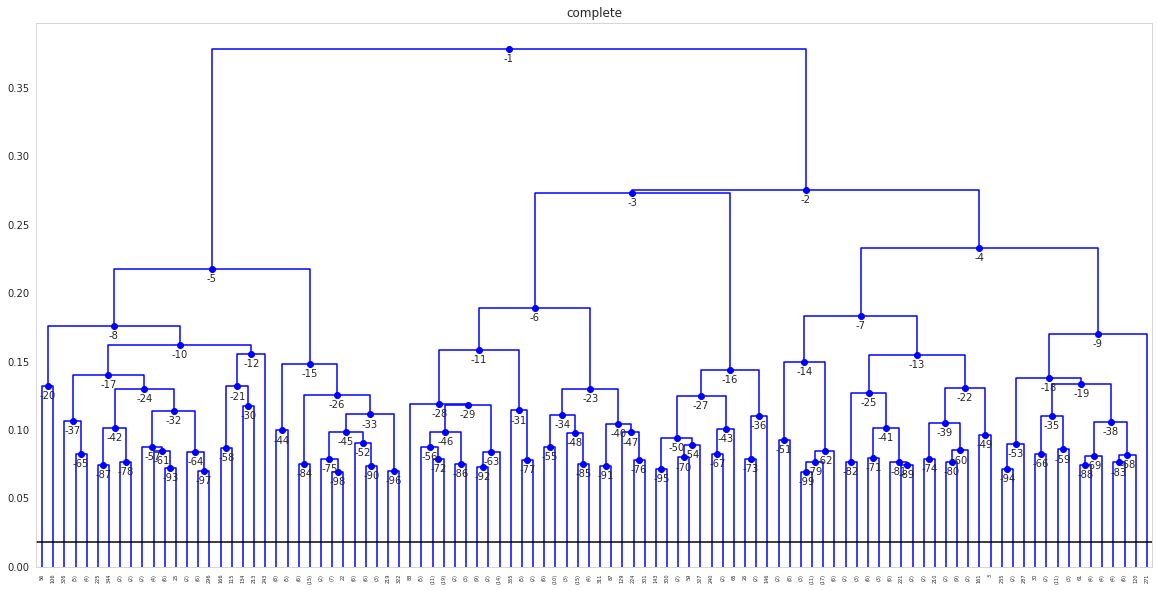

In [16]:
#we tried to check which linkage seemed more suitable for our dataset
methods = ['single', 'average', 'complete']

for method in methods:
    Z = linkage(feat, metric='correlation', method=method, optimal_ordering=True)
    fig, ax = plot_dendrogram(Z=Z, X=feat, truncate_mode='lastp', p=100, n_clusters=0)
    ax.set_title(method)

Different linkages resulted into different dendrograms.
In particular, the one obtained with complete linkage resulted less chaotic, due to the robustness to outliers of this linkage and we decided to select this one for our agglomerative clustering.
From distance knowledge provided by the dendrogram and by informations about the dataset we decided to start by  cutting the dendrogram to obtain 8 clusters.

(<Figure size 1440x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f005aaca390>)

Total Purity: 0.4850136238613725
Silhouette Coefficient 0.1322422791249141


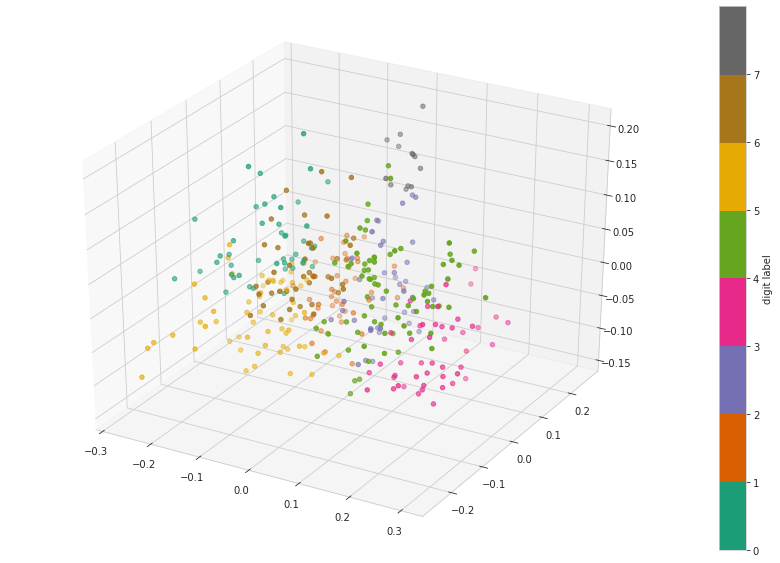

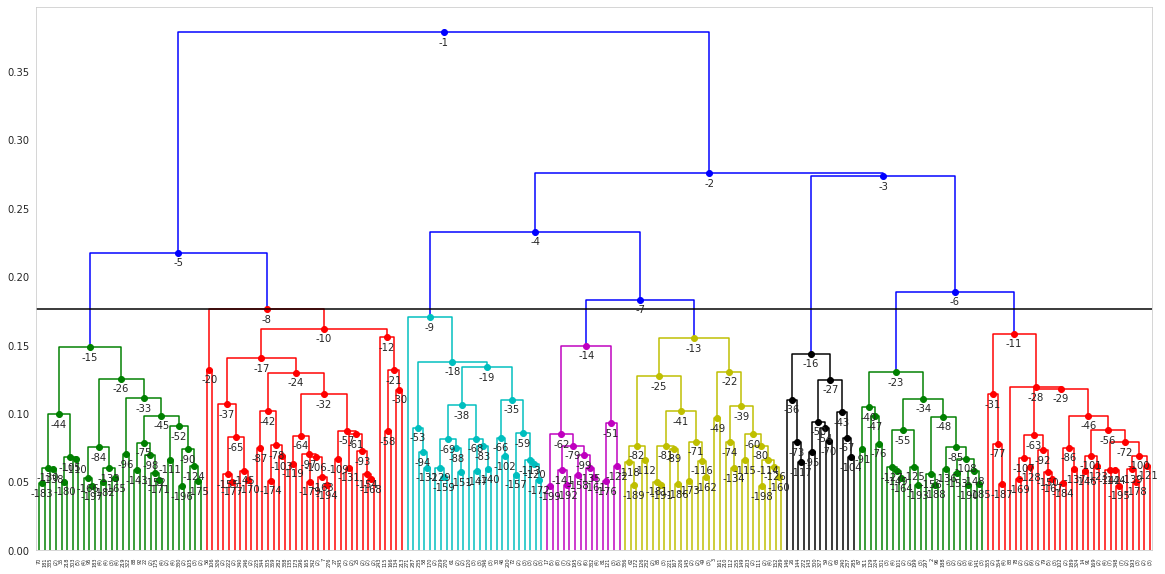

In [17]:
#Agglomerative clustering results graphical results
distance_threshold=None#270
n_clusters=8

model8 = AgglomerativeClustering(n_clusters=n_clusters, 
                                distance_threshold=distance_threshold, 
                                affinity='correlation', linkage='complete')

y_predict = model8.fit_predict(feat)
plot3d(feat, labels=y_predict)
plot_dendrogram(model=model8, X=feat, truncate_mode='lastp', p=200, 
                n_clusters=n_clusters, color_threshold=distance_threshold)
TP = tot_purity(y_predict, cl)
SIL = silhouette_score(feat, y_predict, metric='correlation')
print ("Total Purity:", TP)
print ("Silhouette Coefficient", SIL)

The goodness of clustering algorithm was evaluated with **total purity**, external index of clustering evaluation given by the mean of the maximum precision of the class of the generated clusters, and **Silhouette score** which were **0.485** and **0.13**, respectively.

Not considering the **Silhouette score** satisfying, we decided to plot **Silhouette score** for different number of clusters in order to investigate the one with the best tradeoff between cohesion and separation.

<Figure size 936x648 with 0 Axes>

Text(0.5, 1.0, 'Silhouette score evaluation')

Text(0.5, 0, 'Number of clusters')

Text(0, 0.5, 'Average Silhouette score')

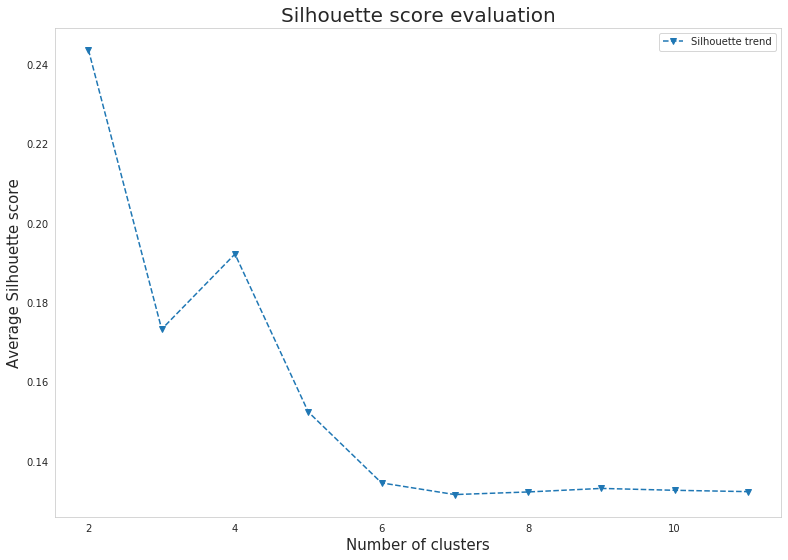

In [18]:
wss_list, bss_list, sil_list = [], [], []
clus_list = list(range(1, 12))
for nc in clus_list:
    model = AgglomerativeClustering(n_clusters=nc,
                                    affinity='correlation', 
                                    linkage='complete')
    y_predict = model.fit_predict(feat)

    if nc > 1:
        sil_list.append(silhouette_score(feat, y_predict, metric='correlation'))

plt.figure(figsize= (13,9))
plt.plot(clus_list[1:], sil_list, label= "Silhouette trend", marker ="v", linestyle="--")
plt.legend()
plt.title("Silhouette score evaluation", fontsize=20)
plt.xlabel("Number of clusters", fontsize=15)
plt.ylabel("Average Silhouette score", fontsize=15)

The curve suggested to cut at **2 clusters** which corresponds to the **highest Average Silhouette Score of 0.24**.
This result could be consistent to the fact that mice are devided in 8 classes based on three binary conditions: presence/absence of trisomy, treatment/not treatment and stimulation/no stimulation that could have greater distance than the one between the 8 groups for the unsupervised learnig method.
So we decided to cut at 2. As expected, we noticed a reduction in the total purity since it is a mean depending on the number of clusters.

(<Figure size 1440x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f005a496650>)

Agglomerative clustering k=2 evaluation

Total Purity: 0.23705722069478447
Silhouette Coefficient 0.24358802966275947


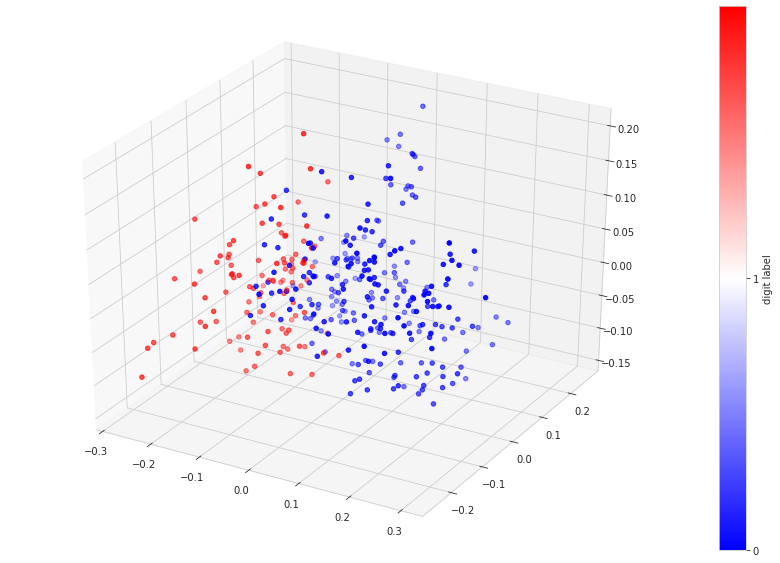

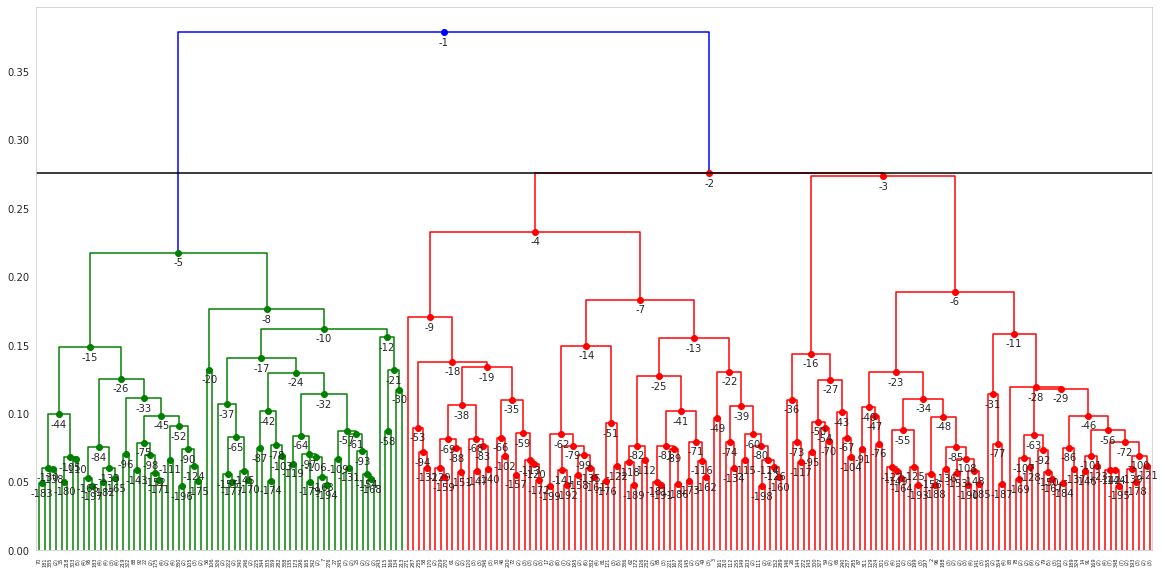

In [19]:
#Agglomerative clustering results graphical results
distance_threshold=None#270
n_clusters=2

model2 = AgglomerativeClustering(n_clusters=n_clusters, 
                                distance_threshold=distance_threshold, 
                                affinity='correlation', linkage='complete')

y_predict = model2.fit_predict(feat)
plot3d(feat, labels=y_predict)
plot_dendrogram(model=model2, X=feat, truncate_mode='lastp', p=200, 
                n_clusters=n_clusters, color_threshold=distance_threshold)
print("Agglomerative clustering k=2 evaluation\n")
TP = tot_purity(y_predict, cl)
print ("Total Purity:", TP)
SIL = silhouette_score(feat, y_predict, metric='correlation')
print ("Silhouette Coefficient", SIL)

However, silhouette coefficient resulted too low and we decided to try with a different approach.

##### 3.3.2 Density based clustering: DBSCAN

We tried to perform clustering based on density.
In this case, we did not need to provide a desired number of clusters or distance/linkage metrics but we needed to find epsilon, the maximum radius that defines the neighborhood of a point and the minimum number of points required to say that a point is in an high density space.
To estimate these hyperparameters we plotted k-nearest neighbour graph and performed gridsearch cross-validation as follows:

<Figure size 936x576 with 0 Axes>

Text(0.5, 1.0, 'K-nearest neighbour graph')

Text(0.5, 0, 'Sorted points based on distance')

Text(0, 0.5, 'Distance from k-nearest neighbor')

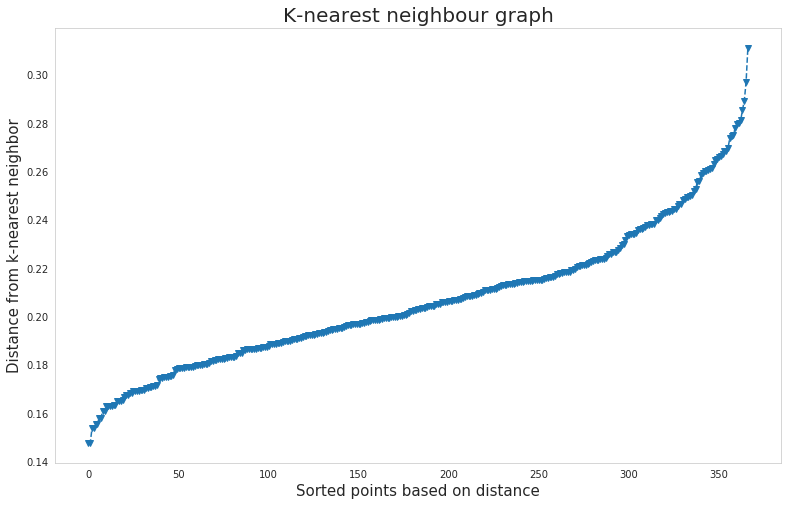

In [20]:
#identification of eps thanks to the k-nearest neighbour graph
#establish an arbitrary number of k neighbors
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(feat)
distances, indices = nbrs.kneighbors(feat)

#sort points based on ascending distance 
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize= (13,8))
plt.plot(distances, marker ="v", linestyle="--")
plt.title("K-nearest neighbour graph", fontsize=20)
plt.xlabel("Sorted points based on distance", fontsize=15)
plt.ylabel("Distance from k-nearest neighbor", fontsize=15)

#The optimal value for epsilon is the distance just before the change in slope of the curve
#We decided to approximate at 0.23

In [21]:
# We redefined make_scorer function to use fit_predict() of DBSCAN instead of predict() method that would be required as default
def make_scorer(metric):
    def scorer(estimator, X, y):
        y_pred = estimator.fit_predict(X)
        return metric(y_pred, y)
    return scorer

In [22]:
#Grid Search of the number of MinPts providing highest purity
params = {'eps': [0.23], 'min_samples': range(5,20)}
cv = GridSearchCV(DBSCAN(), params, scoring=make_scorer(tot_purity), cv=5)
cv = cv.fit(feat, cl)
#and print the results
print(cv.best_params_)

{'eps': 0.23, 'min_samples': 5}


DBSCAN evaluation

Total Purity: 0.12534059945062748
Number of outliers 83
  -1    0
  83  284


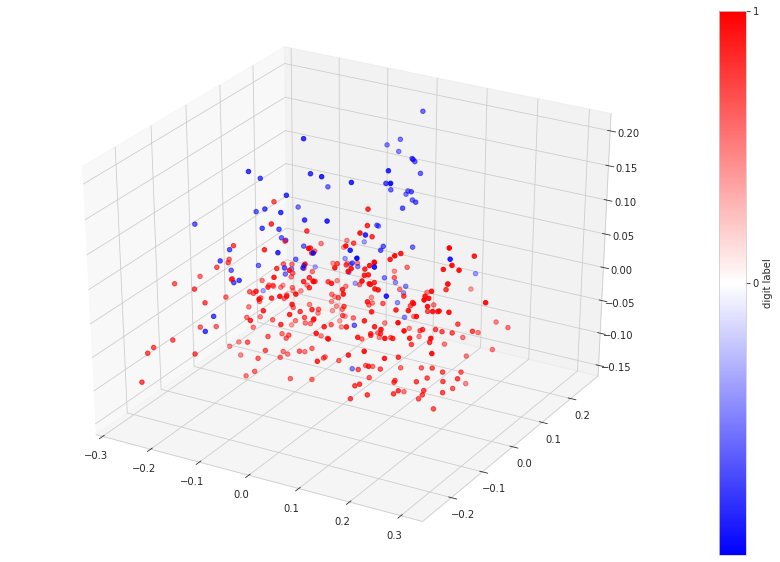

In [23]:
#Performing DBSCAN clustering with eps=0.23 and MinPts=5
modeldb = DBSCAN(eps=0.23, min_samples=5)
y_predictdb = modeldb.fit_predict(feat)

print("DBSCAN evaluation\n")
TP = tot_purity(y_predictdb, cl)
print ("Total Purity:", TP)
print("Number of outliers", (y_predictdb == -1).sum())
ids, counts = np.unique(y_predictdb, return_counts=True)
print(pd.DataFrame(counts.reshape(1,-1), columns=ids, index=['']))

plot3d(feat, labels=y_predictdb)

#we did not used internal coefficients for the evaluation since are based on distance and 
#might be misleading for density based clustering

Performing DBSCAN with epsilon= 0.3 and Minimum number of points=5 we obtained 83 outliers and 284 points clustered in the same cluster. The purity of the clustering algorithm resulted very low only 0.12, approximately half of the one provided by agglomerative clustering with 2 clusters. This result could be caused by the fact that DBSCAN tend not to provide excellent results in case of not uniform density or in case of high dimensional data as in our case.

##### 3.3.3 K-Means clustering

Consequently, we performed the K-means partitioning clustering starting by setting again 8 number of clusters. Since we knew that the initialization represent a crucial step in order to prevent local optimums, we decided to perform the K-means based on k-means++ initialization instead on the random one.

Evaluation of 2 clusters
Total Purity: 0.23433242505518986
Silhouette Coefficient 0.2792236379745407
Evaluation of 4 clusters
Total Purity: 0.3460490462834439
Silhouette Coefficient 0.2107867591940296
Evaluation of 8 clusters
Total Purity: 0.4877384195104608
Silhouette Coefficient 0.14889304522700897


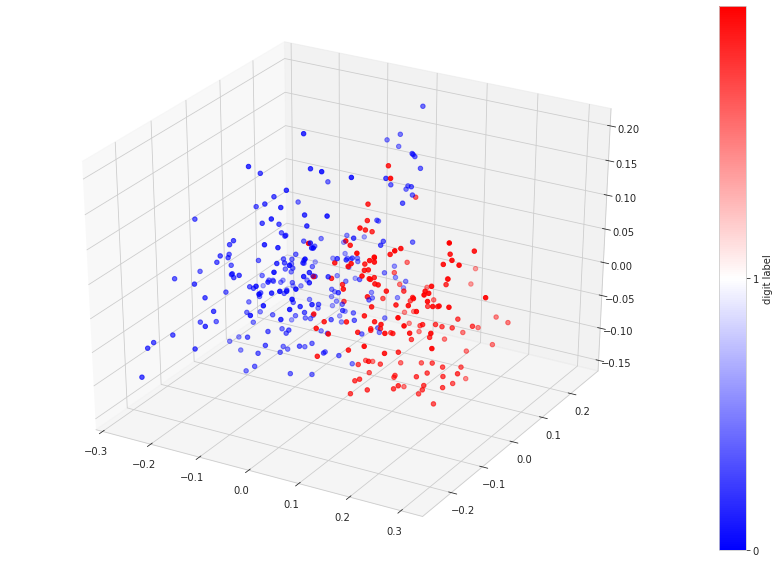

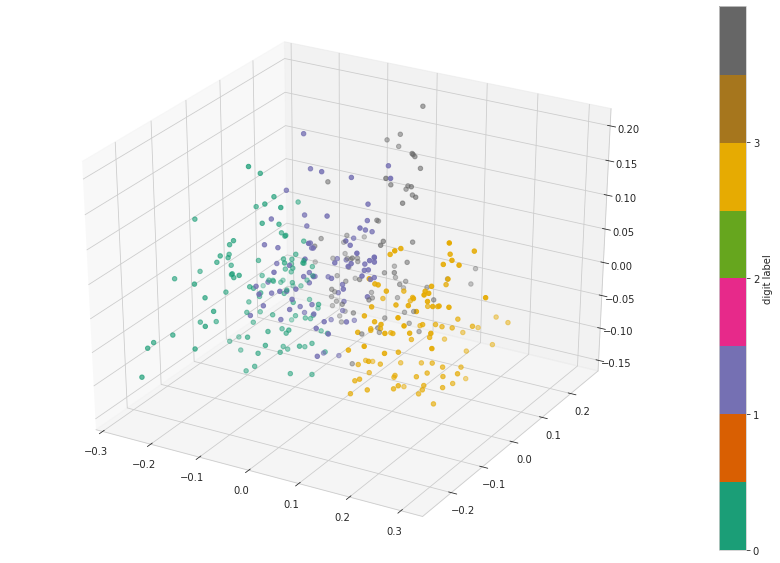

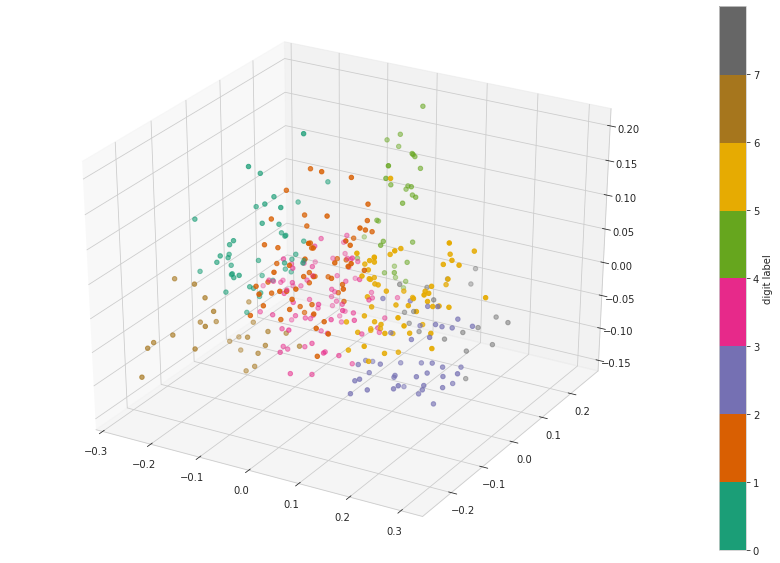

In [24]:
def K_means_fz (n_clusters, init_type, n_init=10):
    modelk = KMeans(n_clusters= n_clusters, init=init_type, random_state=0)             
    y_predictk = modelk.fit_predict(feat)
    plot3d(feat, labels=y_predictk)
    TP = tot_purity(y_predictk, cl)
    print ("Total Purity:", TP)
    SIL = silhouette_score(feat, y_predictk, metric='correlation')
    print ("Silhouette Coefficient", SIL)

clusters = [2,4,8]

for n in clusters:
    print ("Evaluation of {} clusters". format(n))
    K_means_fz (n, "k-means++")

We observed slightly lower total purities but slightly higher silhouette coefficients compared to the hierarchical clustering.
Therefore, knowing that k-means clustering performance are deeply affected by high dimensionality, we tried to obtain better performances performing by reducing dimensionality with Principal Component Analysis (PCA).

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

<Figure size 1080x720 with 0 Axes>

Text(0.5, 1.0, 'Explained Variance by Components')

Text(0.5, 0, 'number of components')

Text(0, 0.5, 'Cumulative Explained Variance')

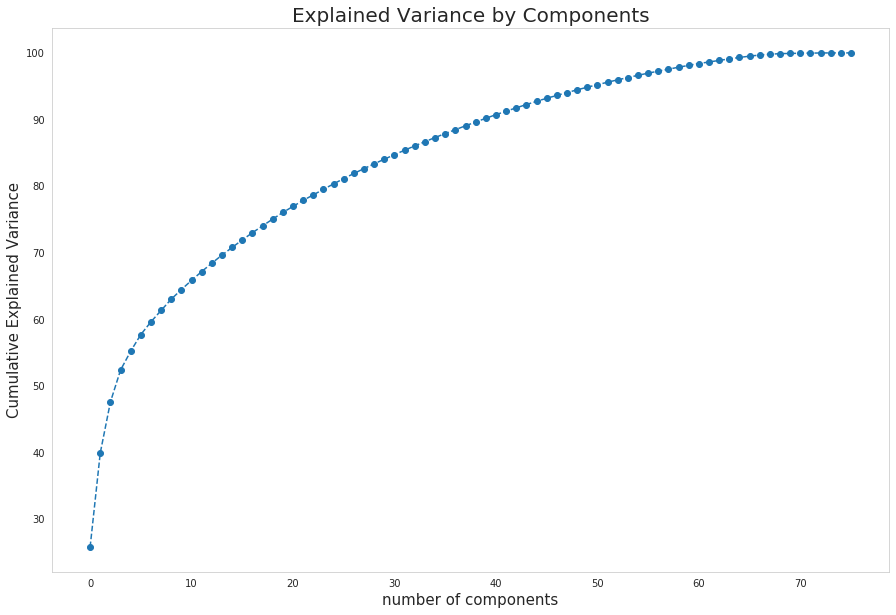

In [25]:
%matplotlib inline
#remember of the predictors and response variable
#remember that feat has already been normalized 
X = feat
y = cl

pca = PCA()
pca.fit(X)
#pca.explained_variance_ratio_
cum = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
#visualization
plt.figure(figsize= (15,10))
plt.plot(cum, marker ="o", linestyle="--")
plt.title("Explained Variance by Components", fontsize=20)
plt.xlabel("number of components", fontsize=15)
plt.ylabel("Cumulative Explained Variance", fontsize=15)

In [26]:
# After different attempts we decided to use the first 15 principal components explaining together the 70% of variance 
pca = PCA(n_components=15)
pca.fit(X)
scores= pca.transform(X)

PCA(copy=True, iterated_power='auto', n_components=15, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [27]:
#useful functions for evaluation
def incidence_mat(y_pred):
    npoints = y_pred.shape[0]
    mat = np.zeros([npoints, npoints])
    # Retrieve how many different cluster ids there are
    clusters = np.unique(y_pred)
    nclusters = clusters.shape[0]
    
    for i in range(nclusters):
        sample_idx = np.where(y_pred == i)
        # Compute combinations of these indices
        idx = np.meshgrid(sample_idx, sample_idx)
        mat[idx[0].reshape(-1), idx[1].reshape(-1)] = 1
        
    return mat

def similarity_mat(X, metric):
    dist_mat = pairwise_distances(X, metric=metric)
    min_dist, max_dist = dist_mat.min(), dist_mat.max()
    
    sim_mat = 1 - (dist_mat - min_dist) / (max_dist - min_dist)
    return sim_mat

def sorted_sim(sim, y_pred):
    idx_sorted = np.argsort(y_pred)
    # Sort the rows
    sim = sim[idx_sorted]
    # Sort the columns
    sim = sim[:, idx_sorted]
    
    return sim

def plot_sorted_sim(sim, y_pred):
    sim = sorted_sim(sim, y_pred)
    
    fig, ax = plt.subplots(figsize=(13,9))  
    ax = sns.heatmap(sim, ax=ax)
    # Remove ruler (ticks)
    ax.set_yticks([]) 
    ax.set_xticks([])
    
def correlation(X, y_pred, metric):
    inc = incidence_mat(y_pred)
    sim = similarity_mat(X, metric)
    inc = normalize(inc.reshape(1, -1))
    sim = normalize(sim.reshape(1, -1))
    corr = (inc @ sim.T)
    return corr[0,0]

Evaluation of 2 clusters K-means on PCA data

Total Purity: 0.23433242505518986
Silhouette Coefficient 0.39075655381356955
correlation score between similarity matrix and incidence matrix: 0.8267761378859106
Evaluation of 8 clusters K-means on PCA data

Total Purity: 0.49863760206527596
Silhouette Coefficient 0.24720085450827103
correlation score between similarity matrix and incidence matrix: 0.5396913024855163


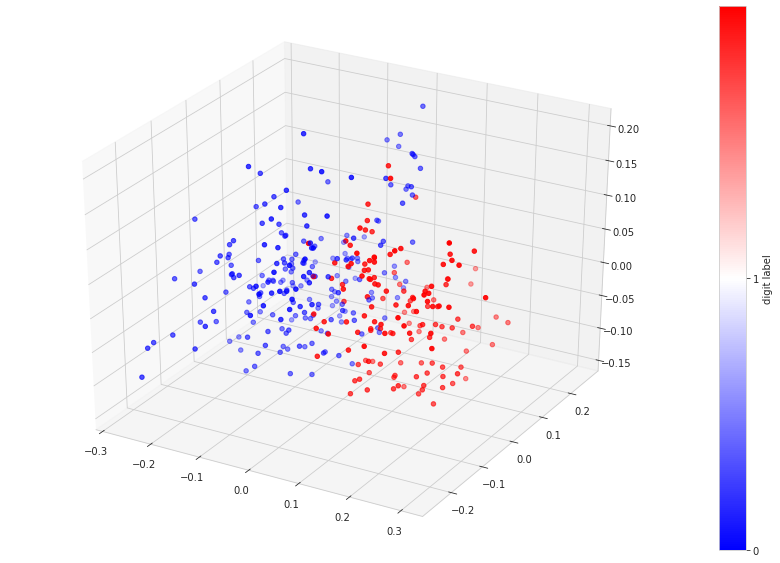

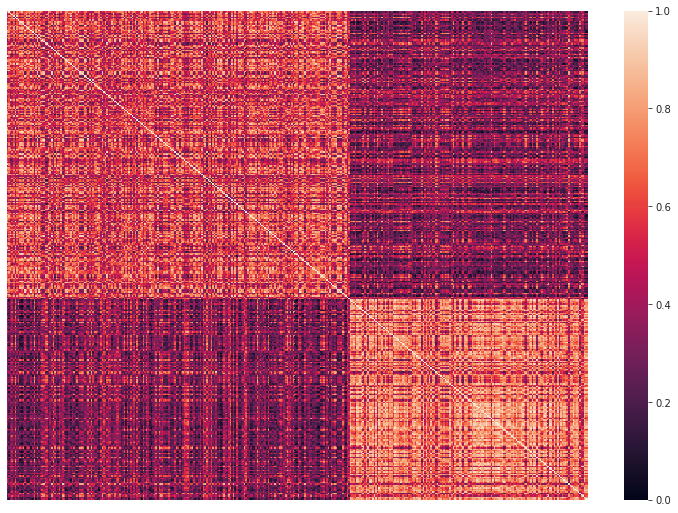

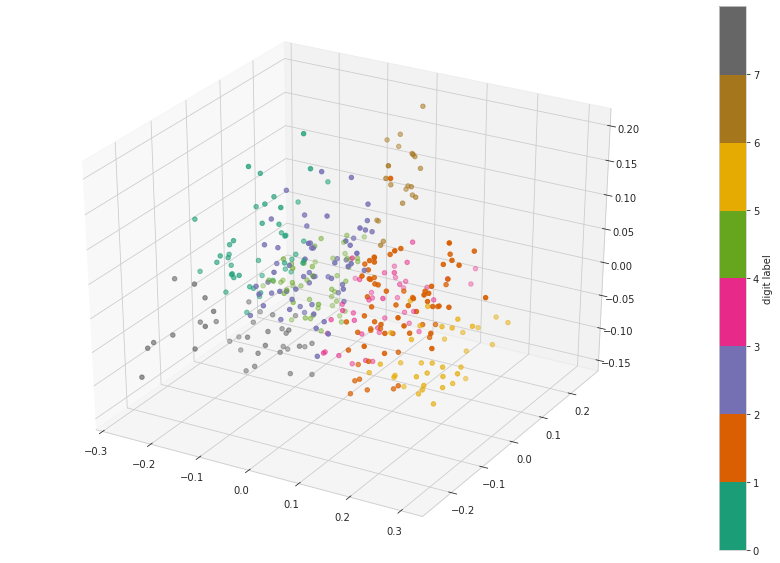

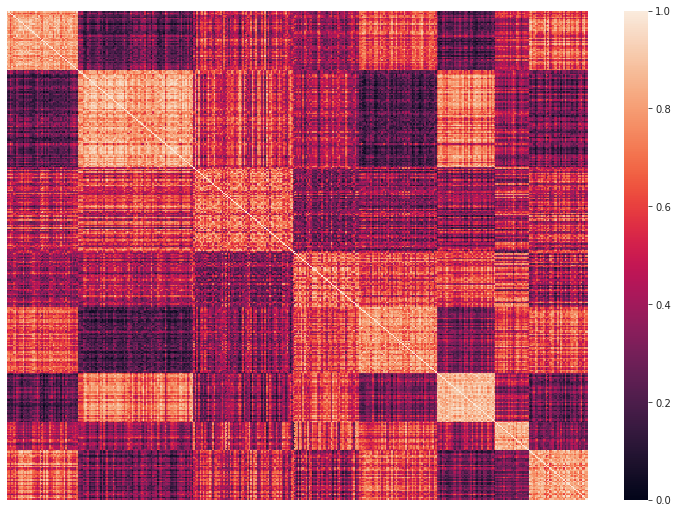

In [28]:
def eval_K (modelp):
    y_predictp = modelp.fit_predict(scores)
    plot3d(scores, labels=y_predictp)
    TP = tot_purity(y_predictp, cl)
    print ("Total Purity:", TP)
    SIL = silhouette_score(scores, y_predictp, metric='correlation')
    print ("Silhouette Coefficient", SIL)
    #cluster validity via correlation between similarity matrix and incidence matrix
    print("correlation score between similarity matrix and incidence matrix:",correlation(scores, y_predictp, 'correlation'))
    sim = similarity_mat(scores, 'correlation')
    plot_sorted_sim(sim, y_predictp)

#perform k-means with 2 and 8 clusters with pca data
print ("Evaluation of 2 clusters K-means on PCA data\n")   
modelp = KMeans(n_clusters= 2, init="k-means++", random_state=0) 
eval_K (modelp)  

#for comparison
print ("Evaluation of 8 clusters K-means on PCA data\n")   
modelp = KMeans(n_clusters= 8, init="k-means++", random_state=0) 
eval_K (modelp)

Overall, the best clustering resulted to be k-means with 2 clusters applied on data transformed with PCA with silhouette coefficient of 0.39. Moreover,correlation rbetween similarity matrix and incidence matrix resulted quite high advocating for the meaningfulness of the clustering. Visual inspection of similarity matrix showed two squares arranged to the main diagonal. However, the results were of low quality and not sufficient to properly understand our data, so we proceed with our analysis.

## 4. Classification without SOD1_N expression

In order to classify mice in the 8 different classes  based on their protein expression levels we firstly performed features selection, and than trained different classifiers. Following, we compared them in order to identify the one showing best performances on the training dataset. Finally, we tested the performance of the best algorithm on the provided test dataset.

### 4.1 Features Selection

In [29]:
#SOD1_N feature missing in test samples --> remove SOD1 from this training set 
feat = feat_n.drop("SOD1_N", axis=1)
feat.shape
cl = train_conv["class"].to_numpy().astype(np.float32)
cl.shape

(367, 75)

(367,)

In [30]:
#in order to use cross validation we split our train dataset into training and testing
split_seed = 42
split_test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(feat, cl, test_size=split_test_size, 
                                                    random_state=split_seed)

In [31]:
#Useful function for feature selection
def accuracy(y_pred, y_true):
    return (y_pred == y_true).sum() / y_pred.shape[0]

def get_evaluator(scorer):
    def evaluator(model, X, y, trained=False):
        if not trained:
            model = model.fit(X, y)
        score = scorer(model, X, y)
        return model, score
    return evaluator   

def get_cv_evaluator(scorer, cv=3):
    def evaluator(model, X, y, trained=False):            
        scores = cross_val_score(model, X, y, scoring=scorer, cv=cv)
        if not trained:
            model = model.fit(X, y)
        return model, np.mean(scores)
    
    return evaluator

def get_val_evaluator(scorer, val_size=0.1):
    def evaluator(model, X, y, trained=False):
        X_train_small, X_val, y_train_small, y_val = train_test_split(X, y, 
                                                                      test_size=val_size,
                                                                      random_state=0)
        
        if not trained:
            model = model.fit(X_train_small, y_train_small)
        score = scorer(model, X_val, y_val) 
        
        return model, score
    
    return evaluator

#since we modified it for DBSCAN we import again make_scorer
from sklearn.metrics import make_scorer

In [32]:
#We generate a forward selection function that we use now with logistic regression
#and that we will use later on with linear regression

def forward_selection(Xtrain_pd, ytrain, Xtest_pd, ytest,
                      candidates_evaluator, candidates_argbest, # Metric to be used at 2.b
                      subsets_evaluator, subsets_argbest,       # Metric to be used at 3
                      test_evaluator=None, test_argbest=None,
                      candidates_scorer_name=None,  # Name of 2. figure
                      subsets_scorer_name=None,     # Name of 3. figure
                      verbose=True, weight_step3=0, model_type= "logistic"):   
    test_evaluator = subsets_evaluator if not test_evaluator else test_evaluator
    test_argbest = subsets_argbest if not test_argbest else test_argbest
    
    # Global variable init
    # ====================
    num_features = Xtrain_pd.shape[-1]
    best_candidate_metric = []
    # subsets_* are lists containing one value for each Mk model (the best of the Mk candidates)
    subsets_test = []
    subsets_metric = []        # The best metric of each subset of dimension 'dim'
    subsets_best_features = [] # The best features combination in each subset of dimension 'dim'
    # A figure to keep track of candidates scores in each Mk subset
    plt.figure()
    candidate_fig = plt.subplot(111) # A global matplotlib figure
    num_evaluations = 0        # A conter to keep track of the total number of trials
    
    selected_features = []
    all_features = Xtrain_pd.columns
    
    
    # 1. Train M0
    # ===========
    model = DummyRegressor()
    # Compute (2.b) metrics
    model, score = candidates_evaluator(model, Xtrain_pd[[]], ytrain)
    best_candidate_metric.append(score)
    subsets_best_features.append([])
    _ = candidate_fig.scatter([0], [score], color="b")
    # Compute metric for step 3.
    _, score = subsets_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_metric.append(score)
    _, score = test_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_test.append(score)
    
    # 2. Evaluate all Mk candidates with
    #    k=0...P features
    # =========================================
    for dim in range(len(all_features)):
        candidate_metrics = [] # Keep track of candidates metrics. Will be used to select the best
        candidate_models = []  # Keep track of candidates trained models
        
        # 2.a Fixed the number of features 'dim', look at
        #     all the possible candidate models with that
        #     cardinality
        # ===============================================
            
        remaining_features = all_features.difference(selected_features)

        for new_column in remaining_features:
            Xtrain_sub = Xtrain_pd[selected_features+[new_column]].to_numpy()
            if model_type == "logistic":
                model = LogisticRegression(solver= "newton-cg", max_iter= 100000, penalty="none", class_weight = "balanced", multi_class="multinomial")
            elif model_type == "LDA":
                model = LDA(solver="svd")
            elif model_type == "QDA":
                model = QDA(store_covariance=True)
            else:
                model = LinearRegression(fit_intercept=True)
                
            model, score = candidates_evaluator(model, Xtrain_sub, ytrain)
            candidate_models.append(model)
            candidate_metrics.append(score)
            num_evaluations += 1

        _ = candidate_fig.scatter([Xtrain_sub.shape[-1]]*len(candidate_metrics), candidate_metrics,
                                  color="b")
            
        # 2.b Select the best candidate among those using
        #     the same number of features (2.a)
        # ===============================================
        idx_best_candidate = candidates_argbest(candidate_metrics)
        # Update selected feature
        selected_features.append(remaining_features[idx_best_candidate])
        # Save best candidate features
        best_candidate_metric.append(candidate_metrics[idx_best_candidate])
        best_features = selected_features.copy()
        subsets_best_features.append(best_features)
        
        
        # Compute metric for step 3.
        best_subset_model = candidate_models[idx_best_candidate]
        best_subset_Xtrain = Xtrain_pd[best_features].to_numpy()
        best_subset_Xtest = Xtest_pd[best_features].to_numpy()
        _, score = test_evaluator(best_subset_model, best_subset_Xtest, ytest, trained=True)
        subsets_test.append(score)
        _, score = subsets_evaluator(best_subset_model, best_subset_Xtrain, ytrain, trained=True)
        subsets_metric.append(score)
        num_evaluations += weight_step3 
        
        if verbose:
            print("............")
            print("Best model (M{}) with {} features: {}".format(dim+1, dim+1, best_features))
            print("M{} subset score (3.): {}".format(dim+1, score))
        
    # 3. Among all best candidates with increasing number
    #    of features, select the best one
    # ===================================================
    best_subset_idx = subsets_argbest(subsets_metric)
    best_features = subsets_best_features[best_subset_idx]
    
    if verbose:
        print("\n\nBest configuration has {} features".format(best_subset_idx))
        print("Features: {}".format(subsets_best_features[best_subset_idx]))
        print("Total number of trained models:", num_evaluations)
    
    # Complete the subsets_fig figure by plotting
    # a line connecting all best candidate score
    best_candidate_score_idx = candidates_argbest(best_candidate_metric)
    _ = candidate_fig.plot(range(len(best_candidate_metric)), best_candidate_metric)
    _ = candidate_fig.scatter(best_candidate_score_idx, best_candidate_metric[best_candidate_score_idx],
                              marker='X', label="Best", color="r")
    candidate_fig.set_title(candidates_scorer_name)
    candidate_fig.legend()
    
    # Plot a figure to show how te 3. metric evolves
    plt.figure()
    subsets_fig = plt.subplot(111)
    _ = subsets_fig.plot(range(len(subsets_metric)), subsets_metric, label="Selection (3.) scores")
    _ = subsets_fig.scatter(best_subset_idx, subsets_metric[best_subset_idx],
                              marker='X', label="Best (3.) score", color="r")
    best_test_score_idx = test_argbest(subsets_test)
    _ = subsets_fig.plot(range(len(subsets_test)), subsets_test, label="Test scores")
    _ = subsets_fig.scatter(best_test_score_idx, subsets_test[best_test_score_idx],
                              marker='X', label="Best test score", color="y")
    subsets_fig.set_title(subsets_scorer_name)
    subsets_fig.legend()
    
    #In this case since we can't use adjusted metrics such as BIC, CP and so on, we used the cross 
    #validation accuracy (or classification error) to decide which is the best number of features to select, 
    #while the train accuracy/error was used to select the candidates.

We performed feature selection with 10 fold cross validation for logistic regression

```python
cv = 10
forward_selection(X_train, y_train, X_test, y_test,
                  get_evaluator(make_scorer(accuracy)), np.argmax, # 2.
                  get_cv_evaluator(make_scorer(accuracy), cv), np.argmax, # 3.
                  get_evaluator(make_scorer(accuracy)), np.argmax, # test
                  candidates_scorer_name="Accuracy",
                  subsets_scorer_name="Accuracy (CV)",
                  verbose=True, weight_step3=cv, model_type = "logistic")
```
We obtained best model with 8 features : pPKCG_N, pERK_N, pCAMKII_N, NUMB_N, Tau_N, BRAF_N, AMPKA_N, DSCR1_N. 

In [33]:
# we generate a new training dataset with the features most relevant
# based on forward feature selection
feat_ffs= feat [['pPKCG_N', 'pERK_N', 'pCAMKII_N', 'NUMB_N', 'Tau_N', 'BRAF_N', 'AMPKA_N', 'DSCR1_N']]
feat_ffs.shape
split_seed = 42
split_test_size = 0.3
X_train_ffs, X_test_ffs, y_train_ffs, y_test_ffs = train_test_split(feat_ffs, cl, test_size=split_test_size, 
                                                    random_state=split_seed)

(367, 8)

In [34]:
#another option for feature selection: Lasso feature selection
#In order to do so we fist perform gridsearch to identify the best 
#C ( 1/ lambda) tuning parameter
param_grid = {'C': [1, 3, 4, 5, 6] }
clf = GridSearchCV(LogisticRegression(solver="saga", max_iter= 100000, penalty='l1', class_weight="balanced", 
                                      multi_class="multinomial"), scoring=make_scorer(accuracy), param_grid= param_grid, cv=10)
clf.fit(X_train, y_train)

#CAUTION: IT TAKES TIME TO RUN 

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100000,
                                          multi_class='multinomial',
                                          n_jobs=None, penalty='l1',
                                          random_state=None, solver='saga',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None, param_grid={'C': [1, 3, 4, 5, 6]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(accuracy), verbose=0)

Best selected C parameter: {'C': 3}
  (best 3) CV accuracy: 0.6683076923076923
  (best 3) Test accuracy: 0.6756756756756757


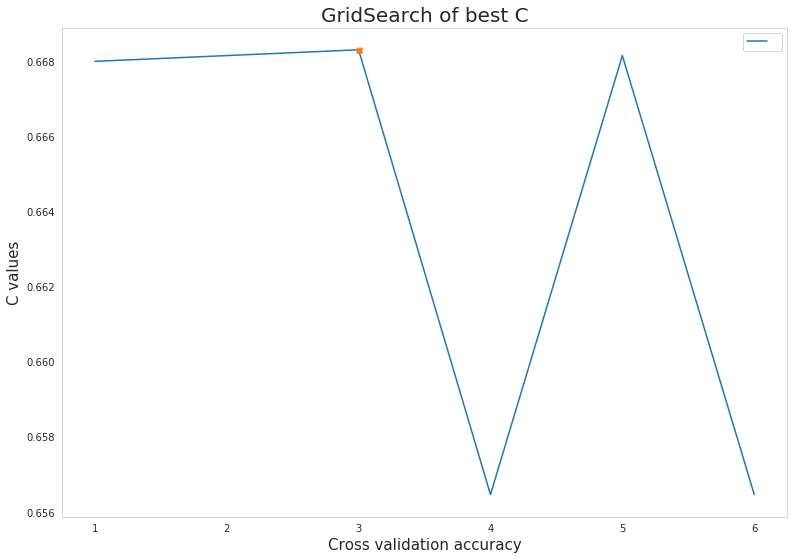

In [35]:
#and check for the best 
print("Best selected C parameter:", clf.best_params_)
def show_results(cv, X_test, params, prefix=''):
    prefix = ' '+prefix    
    results = pd.DataFrame(cv.cv_results_)
    plt.figure(figsize= (13,9))
    plt.title ("GridSearch of best C", fontsize=20)
    plt.plot(results[params], results['mean_test_score'], label=prefix)

    best_idx = np.argmax(results['mean_test_score'])
    plt.plot(results[params][best_idx], 
             results['mean_test_score'][best_idx], marker='X')
    plt.legend()
    plt.xlabel("Cross validation accuracy", fontsize=15)
    plt.ylabel("C values", fontsize=15)
    

    print(prefix, f"(best {results[params][best_idx]}) CV accuracy:",  cv.best_score_)
    print(prefix, f"(best {results[params][best_idx]}) Test accuracy:", accuracy(y_test, cv.best_estimator_.predict(X_test)))
    
show_results(clf, X_test, "param_C")

Following we performed features selection for LDA
```python
cv = 10
forward_selection(X_train, y_train, X_test, y_test,
                  get_evaluator(make_scorer(accuracy)), np.argmax, # 2.
                  get_cv_evaluator(make_scorer(accuracy), cv), np.argmax, # 3.
                  get_evaluator(make_scorer(accuracy)), np.argmax, # test
                  candidates_scorer_name="Accuracy",
                  subsets_scorer_name="Accuracy (CV)",
                  verbose=True, weight_step3=cv, model_type = "LDA")
```

Best model with 18 features pERK_N, pPKCG_N, pCAMKII_N, Tau_N, ERK_N, DYRK1A_N, AMPKA_N, pPKCAB_N, pGSK3B_Tyr216_N, BRAF_N, SYP_N, NUMB_N, CaNA_N, BAD_N, MTOR_N, DSCR1_N, Bcatenin_N, BAX_N
With Cross validation accuracy of 0.863 (the highest for now)

In [36]:
# we generate a new training dataset with the features most relevant
# based on forward feature selection
feat_ffs_LDA= feat[['pERK_N', 'pPKCG_N', 'pCAMKII_N', 'Tau_N', 'ERK_N', 'DYRK1A_N', 'AMPKA_N', 'pPKCAB_N', 'pGSK3B_Tyr216_N', 'BRAF_N', 'SYP_N', 'NUMB_N', 'CaNA_N', 'BAD_N', 'MTOR_N', 'DSCR1_N', 'Bcatenin_N', 'BAX_N']]
feat_ffs_LDA.shape
split_seed = 42
split_test_size = 0.3
X_train_ffs_LDA, X_test_ffs_LDA, y_train_ffs_LDA, y_test_ffs_LDA = train_test_split(feat_ffs_LDA, cl, test_size=split_test_size, 
                                                    random_state=split_seed)

(367, 18)

The features selection for QDA resulted in a 7 features best model

```python
cv = 10
forward_selection(X_train, y_train, X_test, y_test,
                  get_evaluator(make_scorer(accuracy)), np.argmax, # 2.
                  get_cv_evaluator(make_scorer(accuracy), cv), np.argmax, # 3.
                  get_evaluator(make_scorer(accuracy)), np.argmax, # test
                  candidates_scorer_name="Accuracy",
                  subsets_scorer_name="Accuracy (CV)",
                  verbose=True, weight_step3=cv, model_type = "QDA")
```
features : pPKCG_N, DYRK1A_N, pCAMKII_N, Tau_N, BAX_N, NUMB_N, AMPKA_N

In [37]:
# we generate a new training dataset with the features most relevant
# based on forward feature selection
feat_ffs_QDA= feat [['pPKCG_N', 'DYRK1A_N', 'pCAMKII_N', 'Tau_N', 'BAX_N', 'NUMB_N', 'AMPKA_N']]
feat_ffs_QDA.shape
split_seed = 42
split_test_size = 0.3
X_train_ffs_QDA, X_test_ffs_QDA, y_train_ffs_QDA, y_test_ffs_QDA = train_test_split(feat_ffs_LDA, cl, test_size=split_test_size, 
                                                    random_state=split_seed)

(367, 7)

### 4.2 Evaluation of different clustering algorithms

In [38]:
#useful functions to fit and evaluate

#all the outputs provided by commented functions were evaluated in order to perform 
#the most complete choice possible and then commented in order to make the code more reader-friendly

def Classificator_evaluation (model, X, y, y_pred):
    #confusion = confusion_matrix(y, y_pred)
    #cm = plot_confusion_matrix(model, X, y, cmap=plt.cm.Blues)
    #cm.ax_.set_title("Confusion Matrix on test (30% of train set)")
    #print(cm)
    print('Test Accuracy: {:.2f}'.format(accuracy_score(y, y_pred)))
    print('Weighted Precision: {:.2f}'.format(precision_score(y, y_pred, average='weighted')))
    print('Weighted Recall: {:.2f}'.format(recall_score(y, y_pred, average='weighted')))
    #print('Classification Report')
    #print(classification_report(y, y_pred, target_names=['Class 0', 'Class 1', 'Class 2','Class 3', 
                                                         #'Class 4', 'Class 5', 'Class 6', 'Class 7']))
    
def fit_eval (model, X_tr, y_tr, X_test, y_test):
    model.fit(X_tr, y_tr)   
    y_predict= model.predict(X_tr)
    print("Train Accuracy:", accuracy(y_tr, model.predict(X_tr))) 
    Classificator_evaluation ( model, X_test, y_test, model.predict(X_test))

We firstly assumed linear decision boundary and linearity of the k-1 log odds of the a posteriori probability distributions to perform multiple logistic regression on full model, on model restricted to features previously selected and with lasso feature selection.

In [39]:
#train logistic regression no selection
model_Lfull = LogisticRegression(solver="newton-cg", penalty='none', class_weight="balanced", multi_class="multinomial")
print ("Evaluation logistic regression classifier")
fit_eval(model_Lfull, X_train, y_train, X_test, y_test)

Evaluation logistic regression classifier
Train Accuracy: 1.0
Test Accuracy: 0.66
Weighted Precision: 0.69
Weighted Recall: 0.66


In [40]:
#train logistic regression with forward features selection
model_L= LogisticRegression(solver="newton-cg", penalty='none', class_weight="balanced", multi_class="multinomial")
print ("Evaluation logistic regression classifier on selected features")
fit_eval(model_L, X_train_ffs, y_train_ffs, X_test_ffs, y_test_ffs)

Evaluation logistic regression classifier on selected features
Train Accuracy: 0.9453125
Test Accuracy: 0.79
Weighted Precision: 0.82
Weighted Recall: 0.79


In [41]:
#train logistic regression with lasso feature selection
modelL = LogisticRegression(solver="saga", penalty='l1', max_iter= 100000, class_weight="balanced", multi_class="multinomial", C=4)
print ("Evaluation of logistic regression with lasso feature selection")
fit_eval(modelL, X_train, y_train, X_test, y_test)

Evaluation of logistic regression with lasso feature selection
Train Accuracy: 0.98828125
Test Accuracy: 0.66
Weighted Precision: 0.66
Weighted Recall: 0.66


Since validation results were not high, we decided to try Linear discriminant analysis classifier that assumes the likelyhood of data to be distributed as multivariate gaussian with covariance equal for all the classes.
As for logistic regression we performed LDA on complete model and on restricted one according to feature selection results.

In [42]:
#try LDA no selection
modelLDA = LDA(solver="svd")
print ("Evaluation LDA classifier")
fit_eval(modelLDA, X_train, y_train, X_test, y_test)

Evaluation LDA classifier
Train Accuracy: 0.9765625
Test Accuracy: 0.82
Weighted Precision: 0.83
Weighted Recall: 0.82


In [43]:
#try LDA with selected features
modelLDA_s = LDA(solver="svd")
print ("Evaluation LDA classifier on selected features")
fit_eval(modelLDA_s, X_train_ffs_LDA, y_train_ffs_LDA, X_test_ffs_LDA, y_test_ffs_LDA)

Evaluation LDA classifier on selected features
Train Accuracy: 0.9296875
Test Accuracy: 0.87
Weighted Precision: 0.88
Weighted Recall: 0.87


The same workflow was used for Quadratic discriminant analysis, a generative model as the previous ones that assumes the likelyhood of data to be distributed as multivariate gaussian with and different covariances for the classes.

In [44]:
#try with QDA
modelQDA = QDA(store_covariance=True)
print ("Evaluation QDA classifier")
fit_eval(modelQDA, X_train, y_train, X_test, y_test)

Evaluation QDA classifier
Train Accuracy: 1.0
Test Accuracy: 0.20
Weighted Precision: 0.18
Weighted Recall: 0.20


/home/veronica/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [45]:
#try with QDA selected
modelQDA_s = QDA(store_covariance=True)
print ("Evaluation QDA classifier")
fit_eval(modelQDA_s, X_train_ffs_QDA, y_train_ffs_QDA, X_test_ffs_QDA, y_test_ffs_QDA)

Evaluation QDA classifier
Train Accuracy: 1.0
Test Accuracy: 0.85
Weighted Precision: 0.89
Weighted Recall: 0.85


Finally, we also wanted to investigate the performance of Support Vector Machine classifier in the linear case in order to see whether a robust classifier could improve further our results.

In [46]:
#perform Linear SVM with best C according to gridsearch
param_grid = {'C': [0.001 ,0.1,1, 3, 5] }
svm = GridSearchCV(SVC(kernel='linear'), scoring=make_scorer(accuracy), param_grid= param_grid, cv=10)
#C=1 is returned
modelsvm = SVC(kernel='linear', C=1)
fit_eval(modelsvm, X_train, y_train, X_test, y_test)

Train Accuracy: 0.9765625
Test Accuracy: 0.70
Weighted Precision: 0.70
Weighted Recall: 0.70


Since results were lower than the ones of LDA and QDA we decided to deepen our investigation to see whether data were non linearly separable by evaluating different kernel functions.
The polynomial kernel of grade 4 provided lower quality classification of the validation set.

In [48]:
#linear SVM seems to work fine! In order to be sure check degree of 
#kernel function with gridsearch

# Polynomial
param_grid = {'C': np.linspace(0.001, 1, 5,100),
              'coef0': np.linspace(-10, 10, 5),
              'degree': [2, 3, 4]}
svm_poly = GridSearchCV(SVC(kernel='poly'), param_grid,
                        cv=10, scoring='accuracy', refit=True)
svm_poly.fit(X_train, y_train)

# RBF
param_grid = {'C': np.linspace(0.001, 1, 100, 5),
              'gamma': np.linspace(0.001, 100, 5)}
rbf_poly = GridSearchCV(SVC(kernel='rbf'), param_grid, 
                        cv=10, scoring='accuracy', refit=True)
rbf_poly.fit(X_train, y_train)

# Sigmoid
param_grid = {'C': np.linspace(0.001, 1, 100, 5),
              'gamma': np.linspace(0.001, 100, 5),
              'coef0': np.linspace(-10, 10, 5)}
sigm_poly = GridSearchCV(SVC(kernel='sigmoid'), param_grid, 
                         cv=10, scoring='accuracy', refit=True)
sigm_poly.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='poly', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([0.001  , 0.25075, 0.5005 , 0.75025, 1.     ]),
                         'coef0': array([-10.,  -5.,   0.,   5.,  10.]),
                         'degree': [2, 3, 4]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([0.001     , 0.01109091, 0.02118182, 0...
       0.80827273, 0.81836364, 0.82845455, 0.83854545, 0.84863636,
       0.85872727, 0.86881818, 0.87890909, 0.889     , 0.89909091,
       0.90918182, 0.91927273, 0.92936364, 0.93945455, 0.94954545,
       0.95963636, 0.96972727, 0.97981818, 0.98990909, 1.        ]),
                         'gamma': array([1.000000e-03, 2.500075e+01, 5.000050e+01, 7.500025e+01,
       1.000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, ret

GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='sigmoid', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([0.001     , 0.01109091, 0.021181...
       0.85872727, 0.86881818, 0.87890909, 0.889     , 0.89909091,
       0.90918182, 0.91927273, 0.92936364, 0.93945455, 0.94954545,
       0.95963636, 0.96972727, 0.97981818, 0.98990909, 1.        ]),
                         'coef0': array([-10.,  -5.,   0.,   5.,  10.]),
                         'gamma': array([1.000000e-03, 2.500075e+01, 5.000050e+01, 7.500025e+01,
       1.000000e+02])},
             pre_dispatch='2*n_jobs', refit=True

In [52]:
#try SVM non linear best provided by parameters selected with gridsearch
#svm_poly.best_params_  {'C': 0.75025, 'coef0': 10.0, 'degree': 2}
#svm_poly.best_score

svm_model_4 = SVC(kernel='poly', degree=2, coef0=10.0, C=0.75025)
fit_eval(svm_model_4 ,X_train, y_train, X_test, y_test)
#slightly better than linear in case of validation, worse on testing
#the others showed worse performances

Train Accuracy: 0.91796875
Test Accuracy: 0.71
Weighted Precision: 0.71
Weighted Recall: 0.71


In [53]:
results_cl = [[1.0, 0.66, 0.69, 0.66], [0.98, 0.66, 0.66, 0.66], [0.95, 0.79, 0.82, 0.79],  [0.98, 0.82, 0.83, 0.82], [0.93, 0.87, 0.88,0.87],
              
             [1.0, 0.20,0.18, 0.20], [1.0, 0.85, 0.89, 0.85], [0.98, 0.70, 0.70, 0.70], [0.91, 0.71, 0.71, 0.71]]
res_cl_df = pd.DataFrame(results_cl, columns= ["Train accuracy", "Validation accuracy", "Validation Weighted Precision"," Validation Weighted Recall" ], 
                         index= ["Logistic no select", "Logistic lasso select", "Logistic forw select","LDA no select", "LDA forw select", 
                                 "QDA no select", "QDA forw select", "Linear SVM", "Plynomial d2 SVM"])
print("\nSummary table of clustering evaluation metrics")
res_cl_df


Summary table of clustering evaluation metrics


Train accuracy  Validation accuracy  \
Logistic no select               1.00                 0.66   
Logistic lasso select            0.98                 0.66   
Logistic forw select             0.95                 0.79   
LDA no select                    0.98                 0.82   
LDA forw select                  0.93                 0.87   
QDA no select                    1.00                 0.20   
QDA forw select                  1.00                 0.85   
Linear SVM                       0.98                 0.70   
Plynomial d2 SVM                 0.91                 0.71   

                       Validation Weighted Precision  \
Logistic no select                              0.69   
Logistic lasso select                           0.66   
Logistic forw select                            0.82   
LDA no select                                   0.83   
LDA forw select                                 0.88   
QDA no select                                   0.18   
QDA forw select                                 0.89   
Linear SVM                                      0.70   
Plynomial d2 SVM                                0.71   

                        Validation Weighted Recall  
Logistic no select                            0.66  
Logistic lasso select                         0.66  
Logistic forw select                          0.79  
LDA no select                                 0.82  
LDA forw select                               0.87  
QDA no select                                 0.20  
QDA forw select                               0.85  
Linear SVM                                    0.70  
Plynomial d2 SVM                              0.71

Overall, we noticed that very high accuracy on the training dataset corresponded in almost all the cases in a poorer performance on validation set such as in the case of Logistic and QDA on with all the features and the polynomial 
Support Vector machine. 

The best two models resulted QDA  and LDA on set with selected features.
In particular, we noticed a perfect accuracy of 1 for the trainig set for the first one while for LDA we obtained 
a lower value of 0.93 (0.07 of difference). 
However, LDA showed higher accuracy in the part of train set used for 
cross validation with respect to the QDA (0.87 vs 0.85) and a more balanced tradeoff between average precision and recall (0.88 and 0.87 vs 0.89 and 0.85).


For those reason we selected Linear Discriminant Analysis as the best classifier.

### 4.3 Best algorithm performances on test set
The choosen classifier Linear Discrinant Analysis was used on test set.

In [54]:
#we had
feat = feat_n.drop("SOD1_N", axis=1)
cl = train_conv["class"].to_numpy().astype(np.float32)

#training dataset now becomes
feat_train = feat[['pERK_N', 'pPKCG_N', 'pCAMKII_N', 'Tau_N', 'ERK_N', 'DYRK1A_N', 'AMPKA_N', 'pPKCAB_N', 'pGSK3B_Tyr216_N', 'BRAF_N',
                   'SYP_N', 'NUMB_N', 'CaNA_N', 'BAD_N', 'MTOR_N', 'DSCR1_N', 'Bcatenin_N', 'BAX_N']]
cl_train= cl
print ("Rows, columns of input and class of train dataset: \n", feat_train.shape, ",", cl_train.shape)

#prepare test dataset
conversion_dict = {"c-CS-s":0, "t-CS-s":1, "c-CS-m":2, "t-CS-m":3, "c-SC-s":4, "t-SC-s":5, "c-SC-m":6, "t-SC-m":7}
#we replace the strings representing class labels with integer values from 0 to 7
test_conv = test_dataset.replace({"class": conversion_dict})
#we devide our dataframe in inputs and external information about lables
test_n = test_conv.drop("class", axis=1)
feat_test= test_n[['pERK_N', 'pPKCG_N', 'pCAMKII_N', 'Tau_N', 'ERK_N', 'DYRK1A_N', 'AMPKA_N', 'pPKCAB_N', 'pGSK3B_Tyr216_N', 'BRAF_N',
                   'SYP_N', 'NUMB_N', 'CaNA_N', 'BAD_N', 'MTOR_N', 'DSCR1_N', 'Bcatenin_N', 'BAX_N']]
cl_test = test_conv["class"].to_numpy().astype(np.float32)
print ("Rows, columns of input and class of test dataset: \n", feat_test.shape, ",", cl_test.shape)

Rows, columns of input and class of train dataset: 
 (367, 18) , (367,)
Rows, columns of input and class of test dataset: 
 (245, 18) , (245,)


Evaluation LDA Model on train dataset
Train accuracy: 0.9073569482288828
Test accuracy: 0.8734693877551021
Test Weighted Precision: 0.876460477744321
Test Weighted Recall: 0.8734693877551021
Test Weighted F1-score: 0.8736309617845538


Text(0.5, 1.0, 'Confusion Matrix on test set without SOD1_N')

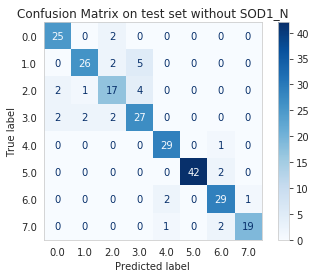

In [55]:
print ("Evaluation LDA Model on train dataset")
modelLDA_test = LDA(solver="svd")
model= modelLDA_test.fit(feat_train, cl_train)   
cl_predict_train= model.predict(feat_train)
cl_predict_test= model.predict(feat_test)
print("Train accuracy:", accuracy(cl_train, model.predict(feat_train))) 
print("Test accuracy:", accuracy(cl_test, model.predict(feat_test)))
print('Test Weighted Precision:', precision_score(cl_test, model.predict(feat_test), average='weighted'))
print('Test Weighted Recall:', recall_score(cl_test, model.predict(feat_test), average='weighted'))
print('Test Weighted F1-score:', f1_score(cl_test, model.predict(feat_test), average='weighted'))
confusion = confusion_matrix(cl_test, cl_predict_test)
cm = plot_confusion_matrix(model, feat_test, cl_test, cmap=plt.cm.Blues)
cm.ax_.set_title("Confusion Matrix on test set without SOD1_N")

#we obtain exactly the same result of cross validation with the small test set obtained by splitting 
#suggesting that the 

Accuracy results of 0.87 on the test set were perfectly in line with our expectations suggesting that our selection strategy was useful
to make a wise choice of the classifier.

## 5. SOD1_N expression prediction
In order to recover from the data loss of SOD1_N feature on test samples, we aimed to train a regressor to predict its value given the other features. 
We tried different algorithms and we compared them with robust techniques.
Once chosen the best regressor, we used it to predict SOD1_N values.

### 5.1 Training different regressors

In [56]:
#Assign SOD1_N column to Y and all other predictors to X 
#in this case we ignore the class column

Xc = train_dataset.drop("class", axis=1)
X = Xc.drop("SOD1_N", axis=1)
y = train_dataset["SOD1_N"]
print("X.shape", X.shape)
print("y.shape", y.shape)

X.shape (367, 75)
y.shape (367,)


In [57]:
test_size = 0.3
test_seed = 42
# Split X and y into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=test_size, 
                                                    random_state=test_seed)
print("X_train.shape ", X_train.shape)
print("X_test.shape ", X_test.shape)

X_train.shape  (256, 75)
X_test.shape  (111, 75)


In [ ]:
#after observing that not all the coefficients were significant,
#we decided to perform feature selection

In [58]:
#function useful for feature selection
def rss(y_true, y_pred):
    # First we make sure the shapes are the same
    y_true = y_true.reshape(y_pred.shape)
    return np.sum((y_true - y_pred) ** 2)

def tss(y):
    return np.sum((y - y.mean()) ** 2)

def multiple_least_squares(X, y):
    model = LinearRegression(fit_intercept=True)
    model.fit(X, y)
    y_pred = model.predict(X)
    betas = [model.intercept_, *model.coef_]
    return betas, y_pred

def estimate_sigma(Xtrain_pd, ytrain):
    # Sigma is usually estimated using the model with all features
    n, p = Xtrain_pd.shape
    model = LinearRegression(fit_intercept=True)
    model.fit(Xtrain_pd, ytrain)
    y_pred = model.predict(Xtrain_pd)
    RSS = rss(y_pred, ytrain)
    RSE = np.sqrt(RSS / (n-p))
    return RSE

alpha = 0.0001
X_all_features = X.columns

X_train_pd = X_train
y_train_pd = y_train
X_test_pd = X_test

sigma = estimate_sigma(X_train, y_train)


```python
forward_selection(X_train, y_train, X_test_pd, y_test,
                  get_evaluator(make_scorer(r2_score)), np.argmax, # 2.b
                  get_cv_evaluator(make_scorer(r2_score), cv=10), np.argmax, # 3.
                  get_evaluator(make_scorer(r2_score)), np.argmax, # test
                  candidates_scorer_name="cv(R^2)",
                  subsets_scorer_name="cv(R^2)",
                  verbose=True, weight_step3=10, model_type= "linear")
```
The best configuration provided a R^2 score of 0.70 with the 20 following features: pERK_N, Bcatenin_N, pPKCAB_N, Tau_N, MTOR_N, ADARB1_N, pPKCG_N, AMPKA_N, pELK_N, AKT_N, ARC_N, DYRK1A_N, BRAF_N, AcetylH3K9_N, nNOS_N, BAD_N, DSCR1_N, pAKT_N, pP70S6_N, pMTOR_N.

In [59]:
X_red= X [['pERK_N', 'Bcatenin_N', 'pPKCAB_N', 'Tau_N', 'MTOR_N', 'ADARB1_N', 'AMPKA_N', 'pPKCG_N', 'AKT_N', 'nNOS_N', 'pELK_N', 'DSCR1_N', 'pNR2A_N', 'ERK_N', 'CAMKII_N', 'RAPTOR_N', 'ARC_N', 'NR2A_N', 'EGR1_N', 'BRAF_N', 'IL1B_N', 'CDK5_N']]
X_red.shape
#perform the split
test_size = 0.3
test_seed = 60
# Split X and y into train and test
X_train_red, X_test_red, y_train, y_test = train_test_split(X_red, y,
                                                    test_size=test_size, 
                                                    random_state=test_seed)

(367, 22)

In [60]:
def fit_eval_regr (model, X_tr, y_tr, X_test, y_test):
    model.fit(X_tr, y_tr)   
    y_predict= model.predict(X_tr)      
    y_predict_test = model.predict(X_test)
    y_predict_train = model.predict(X_tr)
    print("Train R2 score ", r2_score(y_tr, y_predict_train))
    print("Test R2 score ", r2_score(y_test, y_predict_test))
    print("\nTrain MSE score ", mean_squared_error(y_tr, y_predict_train))
    print("Test MSE score ", mean_squared_error(y_test, y_predict_test))
    
    plt.figure(figsize= (15,10))
    plt.title("Residual plot", fontsize=20)
    plt.scatter(y_predict_train, (y_predict_train - y_tr))
    plt.hlines(y=0, xmax=1.5, xmin = 0, colors="red")
    plt.ylabel("Residuals")

In [61]:
#to choose the degree of our regressor we perform GridSearch
r2_scorer = make_scorer(r2_score,
                        greater_is_better=True)
d=[2,3,4]
# Validation
model = Pipeline([('poly', PolynomialFeatures(degree=d, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=True))])

# Select parameters to optimize
parameters = {'poly__degree': list(range(1,5))}
              #'linear__fit_intercept': [True, False],
              #'linear__normalize': [True, False]}

cv = GridSearchCV(model, parameters, scoring=r2_scorer, cv=5)
cv.fit(X_train_red, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('poly',
                                        PolynomialFeatures(degree=[2, 3, 4],
                                                           include_bias=False,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('linear',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'poly__degree': [1, 2, 3, 4]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score

In [62]:
# Retrieve its parameters
print("Best Parameter:", cv.best_params_)
# Retrieve the best **CV** score (=mean of the scores on each fold)
print("Best Score:", cv.best_score_)
#all results
pd.DataFrame(cv.cv_results_)

Best Parameter: {'poly__degree': 1}
Best Score: 0.6999486867217612


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.007350      0.001077         0.004634        0.005285   
1       0.014543      0.000560         0.001721        0.000034   
2       0.036582      0.000078         0.002580        0.000075   
3       0.205559      0.005690         0.006446        0.000690   

  param_poly__degree               params  split0_test_score  \
0                  1  {'poly__degree': 1}           0.683905   
1                  2  {'poly__degree': 2}          -0.776328   
2                  3  {'poly__degree': 3}           0.395160   
3                  4  {'poly__degree': 4}           0.275004   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.825286           0.725022           0.699014           0.566517   
1          -1.932050          -1.723706          -1.784815          -2.001227   
2           0.097437          -3.152744          -0.459011          -0.148142   
3          -0.052703         -14.482006          -0.931010          -0.058315   

   mean_test_score  std_test_score  rank_test_score  
0         0.699949        0.082946                1  
1        -1.643625        0.444887                3  
2        -0.653460        1.280861                2  
3        -3.049806        5.730105                4

Train R2 score  0.7611604448342753
Test R2 score  0.7570256857309481

Train MSE score  0.020604546339512225
Test MSE score  0.018542080110775346


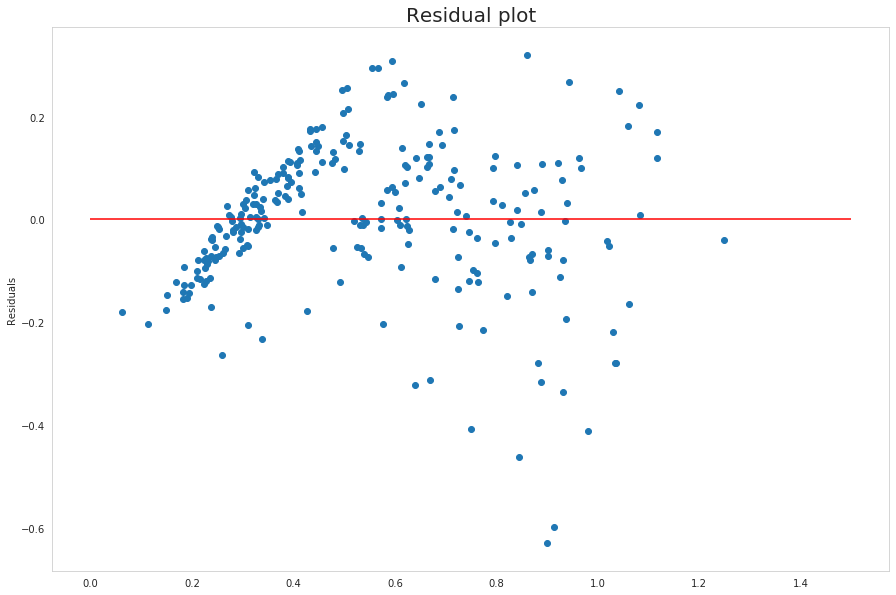

In [63]:
#since results suggest to use a linear regression, we train it on the reduced model
modellr = cv.best_estimator_  #best trained estimator
fit_eval_regr (modellr, X_train_red, y_train, X_test_red, y_test)

The presence of a pattern in the residual plot suggests that we might not have linear data, however, 
performing a non linear transformation of the predictors with polynomial regression resulted in lower 
cross validation scores suggesting an overfitting on the training set.

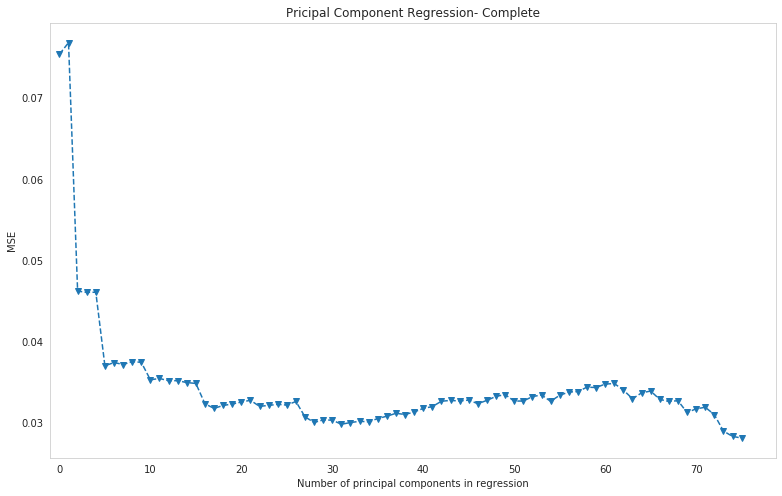

In [64]:
#Since our aim was prediction, we tried to deal with multicollinearity by performing a principal component regression
#in order to search for better results

# Split into training and test sets
X_train, X_test , y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=1)

pca2 = PCA()

# Scale the data
X_reduced_train = pca2.fit_transform(scale(X_train))
n = len(X_reduced_train)

# 10-fold CROSS VALIDATION + shuffle
kf_10 = model_selection.KFold( n_splits=10, shuffle=True, random_state=1)
regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*model_selection.cross_val_score(regr, np.ones((n,1)), y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 76 principle components, adding one component at the time.
for i in np.arange(1, 76):
    score = -1*model_selection.cross_val_score(regr, X_reduced_train[:,:i], y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.figure(figsize=(13,8))
plt.plot(np.array(mse), '--v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Pricipal Component Regression- Complete')
plt.xlim(xmin=-1);

<Figure size 1440x720 with 0 Axes>

<BarContainer object of 75 artists>

Text(0.5, 1.0, 'PVE of principal components')

Text(0.5, 0, 'PCA features')

Text(0, 0.5, 'variance %')

AttributeError: 'Text' object has no property 'step'

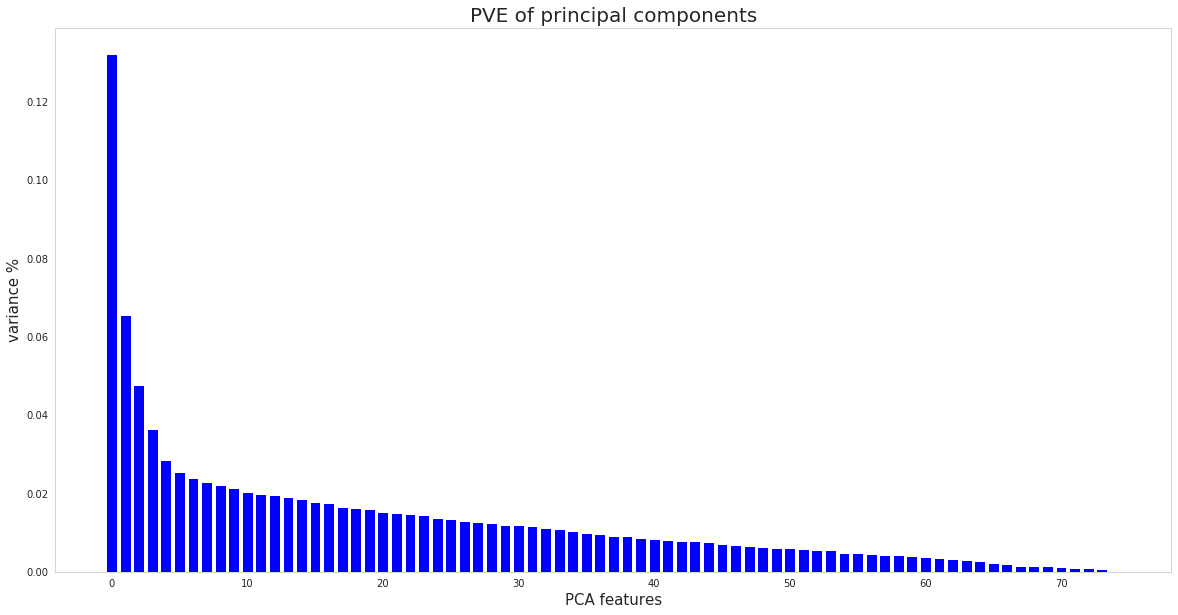

In [65]:
plt.figure(figsize=(20, 10))
plt.bar(range(pca2.n_components_), pca2.explained_variance_ratio_, color='blue')
plt.title("PVE of principal components", fontsize=20)
plt.xlabel('PCA features', fontsize=15)
plt.ylabel('variance %', fontsize=15)
plt.xticks(step = 10) #I'm sorry, can't understand why the error but the graph is like I wanted it to be

In [66]:
var_expl = np.cumsum(np.round(pca2.explained_variance_ratio_, decimals=4)*100)
var_expl
#with 7 PCs only the 37,5% of variability is explained

array([13.22, 19.79, 24.56, 28.2 , 31.05, 33.6 , 36.  , 38.28, 40.5 ,
       42.64, 44.69, 46.67, 48.62, 50.53, 52.39, 54.18, 55.93, 57.58,
       59.22, 60.81, 62.33, 63.84, 65.32, 66.76, 68.15, 69.5 , 70.79,
       72.06, 73.31, 74.52, 75.71, 76.87, 77.98, 79.08, 80.13, 81.11,
       82.07, 82.99, 83.9 , 84.77, 85.61, 86.43, 87.23, 88.01, 88.76,
       89.47, 90.17, 90.84, 91.48, 92.09, 92.69, 93.27, 93.83, 94.38,
       94.86, 95.33, 95.77, 96.2 , 96.63, 97.03, 97.4 , 97.75, 98.08,
       98.39, 98.66, 98.9 , 99.1 , 99.26, 99.41, 99.55, 99.67, 99.77,
       99.86, 99.93, 99.96])

In [67]:
#def function to evaluate 
def eval_pcr (X_test, X_train, y_train, y_test, pc):
    X_reduced_test = pca2.transform(scale(X_test))[:,:pc]
    # Train regression model on training data 
    regr = LinearRegression()
    regr.fit(X_reduced_train[:,:pc], y_train)
    # Prediction with test data
    pred = regr.predict(X_reduced_test)
    print("Test R2 score ", r2_score(y_test, pred))
    print("Test MSE score ", mean_squared_error(y_test, pred))

In [68]:
#try with 16 / 33 and 65 explaining respectively 57% / 80% / 99%
pc = [16, 33, 65]
for n in pc:
    print( "\nEvaluation with {} principal components". format(n))
    eval_pcr(X_test, X_train, y_train, y_test, n)


Evaluation with 16 principal components
Test R2 score  0.4808102193787117
Test MSE score  0.05356146307576389

Evaluation with 33 principal components
Test R2 score  0.5085521289702744
Test MSE score  0.050699509081866774

Evaluation with 65 principal components
Test R2 score  0.5490968270248533
Test MSE score  0.04651677392639117


Overall, the best results, ross validation R^2 of 0.76, were provided by the multivariate linear regressor  with the 20 following features: pERK_N, 
    Bcatenin_N, pPKCAB_N, Tau_N, MTOR_N, ADARB1_N, pPKCG_N, AMPKA_N, pELK_N, AKT_N, ARC_N, DYRK1A_N, BRAF_N, 
    AcetylH3K9_N, nNOS_N, BAD_N, DSCR1_N, pAKT_N, pP70S6_N, pMTOR_N.
    The obtained result is not optimal but can be considered reasonable by taking into account that we were working
    on biological real life data.

## 6. Prediction of SOD1_N values of test dataset
We predicted SOD1_N values of test dataset in order to recover from their loss.

In [69]:
#since this is the best model achieved, we predict SOD1_N on test set 
X = train_dataset[['pERK_N', 'Bcatenin_N', 'pPKCAB_N', 'Tau_N', 'MTOR_N', 'ADARB1_N', 'AMPKA_N', 'pPKCG_N', 'AKT_N', 'nNOS_N', 'pELK_N', 'DSCR1_N', 'pNR2A_N', 'ERK_N', 'CAMKII_N', 'RAPTOR_N', 'ARC_N', 'NR2A_N', 'EGR1_N', 'BRAF_N', 'IL1B_N', 'CDK5_N']]
y = train_dataset["SOD1_N"]
X_test= test_dataset[['pERK_N', 'Bcatenin_N', 'pPKCAB_N', 'Tau_N', 'MTOR_N', 'ADARB1_N', 'AMPKA_N', 'pPKCG_N', 'AKT_N', 'nNOS_N', 'pELK_N', 'DSCR1_N', 'pNR2A_N', 'ERK_N', 'CAMKII_N', 'RAPTOR_N', 'ARC_N', 'NR2A_N', 'EGR1_N', 'BRAF_N', 'IL1B_N', 'CDK5_N']]

In [70]:
# Fit the LinearRegression predictor
model_l = LinearRegression(fit_intercept=True) # 1- hyperparams selection
model_l = model_l.fit(X, y)                    # 2- model fitting
y_predict = model_l.predict(X_test)            # 3- prediction
#add in the same index of SOD1_N in train dataset
test_dataset.insert(loc=32, column="SOD1_N", value=y_predict)
test_dataset.head()

DYRK1A_N   ITSN1_N    BDNF_N     NR1_N    NR2A_N    pAKT_N   pBRAF_N  \
0  0.179263  0.066807  0.415744  1.689743  3.341121  0.544789  0.013569   
1  0.292189  0.721669  0.461519  2.405523  4.632695  0.070489  0.152357   
2  0.618632  0.880618  0.437260  2.339360  3.875806  0.129437  0.047842   
3  0.356012  0.646883  0.450320  2.478821  3.772100  0.122035  0.076693   
4  0.207957  0.402249  0.271787  1.596307  3.073973  0.106266  0.259618   

   pCAMKII_N   pCREB_N    pELK_N  ...     SHH_N     BAD_N     pS6_N   pCFOS_N  \
0   4.505120  0.131921  1.145255  ...  0.140915  0.230128  0.189588  0.314862   
1   3.563931  0.457679  1.798422  ...  0.045180  0.544333  0.273302  0.397962   
2   4.920675  0.350683  1.492872  ...  0.299862  0.075939  0.344712  0.131191   
3   3.225882  0.084315  1.195571  ...  0.409750  0.079850  0.025022  0.102514   
4   2.467713  0.340771  0.891961  ...  0.501047  0.009205  0.113849  0.186703   

      SYP_N  H3AcK18_N    EGR1_N  H3MeK4_N    CaNA_N   class  
0  0.144272   0.302491  0.086637  0.042029  0.998893  c-SC-m  
1  0.277610   0.155784  0.065486  0.093071  1.576650  c-SC-s  
2  0.003888   0.035925  0.330201  0.035484  1.749580  c-CS-m  
3  0.352965   0.080953  0.272696  0.218447  1.322880  t-SC-s  
4  0.468138   0.206692  0.211410  0.114422  1.482459  c-SC-s  

[5 rows x 77 columns]

## 7. Application of the best classifier on training and test set with SOD1_N values

After predicting values of SOD1_N for the test set, we verified whether the recovery from the data loss of this feature improves the performances of the classification with LDA, the classifier that was chosen at step 4.2.

In [71]:
#return to the train set with SOD1 information
feat_train_s = train_conv.drop("class", axis=1)
cl_train_s = train_conv["class"].to_numpy().astype(np.float32)

#new test dataset 
conversion_dict = {"c-CS-s":0, "t-CS-s":1, "c-CS-m":2, "t-CS-m":3, "c-SC-s":4, "t-SC-s":5, "c-SC-m":6, "t-SC-m":7}
#we replace the strings representing class labels with integer values from 0 to 7
test_conv_sod = test_dataset.replace({"class": conversion_dict})
#we devide our dataframe in inputs and external information about lables
feat_test_s= test_conv_sod.drop("class", axis=1)
cl_test_s = test_conv_sod["class"].to_numpy().astype(np.float32)
print ("Rows, columns of input and class of train dataset with sod: \n", feat_train_s.shape, ",", cl_train_s.shape)
print ("Rows, columns of input and class of test dataset with sod: \n", feat_test_s.shape, ",", cl_test_s.shape)

Rows, columns of input and class of train dataset with sod: 
 (367, 76) , (367,)
Rows, columns of input and class of test dataset with sod: 
 (245, 76) , (245,)


By using SOD1_N as an additional feature, we performed a **new feature selection** in order to get rid of features which were **spuriously selected** by the feature selection performed on train dataset without SOD1_N.

```python
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(feat_train_s, cl_train_s, test_size=0.3, 
                                                            random_state= 45)
cv = 10
forward_selection(X_train_s, y_train_s, X_test_s, y_test_s,
                  get_evaluator(make_scorer(accuracy)), np.argmax, 
                  get_cv_evaluator(make_scorer(accuracy), cv), np.argmax,
                  get_evaluator(make_scorer(accuracy)), np.argmax,
                  candidates_scorer_name="Accuracy",
                  subsets_scorer_name="Accuracy (CV)",
                  verbose=True, weight_step3=cv, model_type = "LDA")
```
The best model selected had **14 features** : SOD1_N, BRAF_N, pPKCG_N, Tau_N, NUMB_N, BAX_N, MTOR_N, AMPKA_N, pERK_N, NR2A_N, pCAMKII_N, DYRK1A_N, pP70S6_N, pCREB_N.

In comparison with the fature selection performed without SOD1_N, which selected these features: pERK_N, pPKCG_N, pCAMKII_N, Tau_N, ERK_N, DYRK1A_N, AMPKA_N, pPKCAB_N, pGSK3B_Tyr216_N, BRAF_N, SYP_N, NUMB_N, CaNA_N, BAD_N, MTOR_N, DSCR1_N, Bcatenin_N, BAX_N, we noticed that this time **SOD1_N was selected as the first most significant feature** meaning that it resulted a crucial feature for classification. Moreover, ERK_N, pPKCAB_N, pGSK3B_Tyr216_N, SYP_N, CaNA_N, BAD_N, DSCR1_N and Bcatenin_N did not result significant anymore whilst NR2A_N, pCAMKII_N, pP70S6_N and pCREB_N were selected.

In [72]:
#new sets of data with the selected features only

feat_train_s = feat_train_s[['SOD1_N', 'BRAF_N', 'pPKCG_N', 'Tau_N', 'NUMB_N', 'BAX_N', 'MTOR_N', 
                             'AMPKA_N', 'pERK_N', 'NR2A_N', 'pCAMKII_N', 'DYRK1A_N', 'pP70S6_N', 'pCREB_N']]
feat_test_s = feat_test_s[['SOD1_N', 'BRAF_N', 'pPKCG_N', 'Tau_N', 'NUMB_N', 'BAX_N', 'MTOR_N', 
                           'AMPKA_N', 'pERK_N', 'NR2A_N', 'pCAMKII_N', 'DYRK1A_N', 'pP70S6_N', 'pCREB_N']]


Evaluation of Best Classifier on test set with SOD1_N values

Train Accuracy: 0.896457765667575
Test Accuracy: 0.85
Weighted Precision: 0.85
Weighted Recall: 0.85


Text(0.5, 1.0, 'Confusion Matrix on test set with SOD1_N')

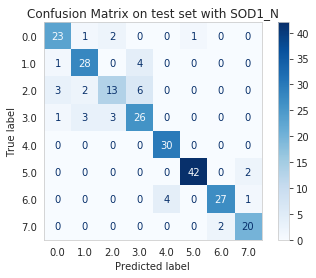

In [73]:
print ("\nEvaluation of Best Classifier on test set with SOD1_N values\n")
modelLDA_s = LDA(solver="svd")
model= modelLDA_s.fit(feat_train_s, cl_train_s)  
fit_eval (model, feat_train_s, cl_train_s, feat_test_s, cl_test_s)

#plot confusion matrix 
confusion = confusion_matrix(cl_test_s, model.predict(feat_test_s))
cm = plot_confusion_matrix(model, feat_test_s, cl_test_s, cmap=plt.cm.Blues)
cm.ax_.set_title("Confusion Matrix on test set with SOD1_N")

In [74]:
results = [[0.91, 0.87, 0.88, 0.87], [0.90, 0.85, 0.85, 0.85]]
res_df = pd.DataFrame(results, columns= ["Train accuracy", "Test accuracy", "Test Weighted Precision","Test Weighted Recall" ], index= ["Before Prediction", "After Prediction"])
res_df

Train accuracy  Test accuracy  Test Weighted Precision  \
Before Prediction            0.91           0.87                     0.88   
After Prediction             0.90           0.85                     0.85   

                   Test Weighted Recall  
Before Prediction                  0.87  
After Prediction                   0.85

The table above summarize our classifier performances of our dataset before and after the recovery from the loss of SOD1_N. Overall, the LDA classifier showed almost identical accuracy on training set both with and without SOD1_N and a slightly lower accuracy, weighted precision and recall on the test set with SOD1_N predicted values.
These difference might be due to predictions errors made by the chosen linear regressor that could have had a negative impact on the classifier algorithm for which SOD1_N feature resulted crucial.